# Backtesting for Market Regime with Nonsupervised Learning
### Lini Zhang

In [2]:

%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import fmt
import quandl
import utils as utl
import sympy as sp
sp.init_printing(use_latex = True)
from IPython.display import display
plt.style.use("ggplot")


Populating the interactive namespace from numpy and matplotlib


D:\Anaconda\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
ETF_symbols = [
                           'XLY',  # XLY Consumer Discrectionary SPDR Fund   
                           'XLF',  # XLF Financial SPDR Fund  
                           'XLK',  # XLK Technology SPDR Fund  
                           'XLE',  # XLE Energy SPDR Fund  
                           'XLV',  # XLV Health Care SPRD Fund  
                           'XLI',  # XLI Industrial SPDR Fund  
                           'XLP',  # XLP Consumer Staples SPDR Fund   
                           'XLB',  # XLB Materials SPDR Fund  
                           'XLU'  # XLU Utilitiy SPDR Fund
                           #'XLRE'     # XLRE real-estate
            ]


In [4]:
# Read data
main_dir = "C:/Users/dell/Documents/Python Scripts/Capstone Project/program development"
sub_dir = "/data"
ETF_data = utl.data_preprocessing(main_dir, ETF_symbols, sub_dir)

In [5]:
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import fmt
import datetime
import time
import statsmodels.tsa.stattools as ts
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
import statistics as stat
from __future__ import division # floating point division in Py2x



Populating the interactive namespace from numpy and matplotlib


In [6]:

# obtain the adjusted close price from ETF dictionary formed data
ETF_adjclose = utl.obtain_adjusted_close(ETF_data)
# create the pandas dataframe for the adjusted close prices       

#ETF_adjclose = pd.DataFrame(ETF_adjclose, index=ETF_data["XLY"].index, columns=ETF_symbols)
# Obtain the percentage change of the adjusted close prices
ETF_pct_change = ETF_adjclose.pct_change().dropna()

tt = 252*7-200
#tt = 252*12-10
ETF_close = ETF_adjclose.iloc[tt:,:]
#t0 = 215
#fmt.display(ETF_close.iloc[t0:,:])

In [7]:
#use the first 10 month as initial dataset for estimation
t0 = 215 #10 month
data = ETF_close.iloc[0:t0,:]
sector_mean = data.mean(axis = 0)
data_mo = data
# use 1 month data to estimate returns for mean reversion strategy 
n = len(data_mo)
data_mr = data.iloc[n-21:,:] 

#fmt.display(data)



In [8]:

# data should not include future prices
def return_sort(data, tnum, bnum):
    # total number of trading days
    T = len(data)
    # total number of stocks
    n = len(data.transpose()) 
    #number of years
    y = T/252.0  
    ret = []
    #annualized return 
    for i in range(n):
        r = (data.iloc[0,i]-data.iloc[T-1,i])/data.iloc[T-1,i]
        r = (1.0+ r)**(1./y) -1.
        ret.append(r) 
    # sort returns in ascending order     
    ret_index = sorted(range(len(ret)),key=lambda x:ret[x]) 
    # select bottom three & top three returns
    stocks=[]
    stocks.append(ret_index[0:bnum])
    stocks.append(ret_index[n-tnum: n])
    print('ret_index = ', ret_index, ' ret = ', ret)
    return stocks
    

def mean_revert_position(wealth, pl, ph):
     
    # calculate shares position with mean reversion strategy
    # pl is prices of bottom stocks
    # ph is prices of top stocks
    # long bottom return stocks
    # short top return stocks
    # p1 is the shares position in shorted bottom stocks
    # p2 is the shares postion in longed top stocks
    
    w = 2.0*wealth/len(pl)   
    wealth_list = [w] * len(pl)
    p1 = list_divide(wealth_list, pl)
    
    w = -wealth/len(ph)
    wealth_list = [w] * len(ph)
    #print(wealth_list)
    p2 = list_divide(wealth_list, ph)    
    position = [p1, p2]
 
    return position


def momentum_position(pl, ph, wealth):
    
    # calculate shares position using momentum strategy
    # pl is prices of bottom stocks
    # ph is prices of top stocks
    # long top return stocks
    # short bottom return stocks
    # assign equal weights of wealth to each stock
    # p1 is the shares position in shorted bottom stocks
    # p2 is the shares postion in longed top stocks
    
    w = -wealth/len(pl) 
    wealth_list = [w] * len(pl)
    p1 = list_divide(wealth_list, pl)
    
    w = 2.0*wealth/len(ph)
    wealth_list = [w] * len(ph)
    p2 = list_divide(wealth_list, ph)
    position = [p1, p2]    
    return position


def mean_reversion_build(t, stocks, prices, position, data_mr, tnum, bnum):
    # build new mean_reversion portfolio
    # given stocks held last period
    # first close position
    # next select new stocks and build new position
    pl, ph = ppair(t, stocks, prices)    
    wealth = close(position, pl, ph, t-1)

    stocks = return_sort(data_mr, tnum, bnum)
    pl, ph = ppair(t, stocks, prices)
    pos = mean_revert_position(wealth, pl, ph)
    return pos, wealth, stocks


def momentum_build(t, stocks, prices, position, data_mo, tnum, bnum):
    # build new momentum portfolio
    # given stocks held last period
    # first close position
    # next select new stocks and build new position
    pl, ph = ppair(t, stocks, prices)
    wealth = close(position, pl, ph, t-1)

    stocks = return_sort(data_mo, tnum, bnum)
    pl, ph = ppair(t, stocks, prices)
    pos = momentum_position(pl, ph, wealth)
    
    return pos, wealth, stocks


def close(position, pl, ph, end_t):
    # close position when switch regime 
    # sum up portfolio values in short/long positions
    # end_t is one period head    
    wealth = list_inner_product(position[end_t][0], pl) + list_inner_product(position[end_t][1], ph)
    return wealth


def wealth_cal(pos, stocks, time, prices):
    # sum up portfolio values in short/long positions
    # the difference in the definitions of wealth_cal and close is the timing of position 
    pl, ph = ppair(time, stocks, prices)
    wealth = list_inner_product(pos[0], pl) + list_inner_product(pos[1], ph)
    return wealth


def ppair(t, pairs, prices):
    pl=[]
    for i in range(len(pairs[0])):
        pl.append(prices.iloc[t][pairs[0][i]])
    ph=[]
    for j in range(len(pairs[1])):
        ph.append(prices.iloc[t][pairs[1][j]])
    return pl, ph


  
    
def list_divide(a, b):
    # a and b are two lists
    # a = [1, 2, 3]
    # b = [2, 8, 9]
    # return [0.5, 0.25, 0.333]
    return [x/y for x, y in zip(a, b)]



def list_inner_product(a, b):
    # a and b are two lists
    # a = [1, 2, 3]
    # b = [0, 1, 4]
    # return 0+ 2+ 12 = 14
    return sum([x*y for x,y in zip(a, b)])



In [9]:

#suppose we are given a series of trading signals
#we trade based on the strategies and trading signals.

# suppose the current signal is mean-reversion
# we need to identify a cointegrated pair in the 10 sectors

# suppose the current signal is momentum
# we identify two stocks for momentum strategy
 

# trading signals
# signal = 0  is mean reversion
# signal = 1 is momentum 

def macro_backtesting(signals, k_mr, k_mo, data_mo, data_mr, ETF_close, tickers, tnum, bnum, t0, dates):
   
    # list initialization 
    position = []  
    stock_track = []
    wealth_path = []    

    
    prices = ETF_close.iloc[t0:, :]
    regimes = ['mean_revertion', 'momentum']
    periods = len(signals)


    # first trading period
    t = 0
    wealth = 1.0e+7

    if signals[0] == 0:
        #momenturm
        regime_state = 0
        stocks = return_sort(data_mo, tnum, bnum)
        pl, ph = ppair(t, stocks, prices)
        pos = momentum_position(pl, ph, wealth)
        count_mo = 1

    else:
        #mean reversion
        regime_state = 1
        stocks = return_sort(data_mr, tnum, bnum)
        pl, ph = ppair(t, stocks, prices)
        pos = mean_revert_position(wealth, pl, ph)
        count_mr = 1
        
    position.append(pos)
    stock_track.append(stocks)
    wealth_path.append(wealth)
    df = ETF_close.iloc[t0+t,:]
    data_mr = data_mr.drop(data_mr.index[0])
    data_mo = data_mo.drop(data_mo.index[0])
    data_mo = data_mo.append(df)
    data_mr = data_mr.append(df)
   

    print('Here starts daily trading: ')
    print('t = ', t, 'regime = ', signals[0], 'wealth = ', wealth)



    for t in range(1, periods):
        signal = signals[t]    

        if (regime_state == 0 and signal == 1):
            #switch to mean reversion        
            stocks = stock_track[t-1]
            pos, wealth, stocks = mean_reversion_build(t, stocks, prices, position, data_mr, tnum, bnum)
            regime_state = 0
            count_mr = 1

        elif (regime_state == 1 and signal == 0):
            #switch to momentum
            stocks = stock_track[t-1]            
            pos, wealth, stocks = momentum_build(t, stocks, prices, position, data_mo, tnum, bnum)
            regime_state = 0
            count_mo = 1

        elif (regime_state == 1 and signal == 1):
            # stay in mean reversion
            # update stocks in portfolio every k_mr days            
            if (count_mr % k_mr == 0 ):
                stocks = stock_track[t-1]
                pos, wealth, stocks = mean_reversion_build(t, stocks, prices, position, data_mr, tnum, bnum)
                
            else:                 
                stocks = stock_track[t-1]
                pos = position[t-1]
                wealth = wealth_cal(pos, stocks, t, prices)
            count_mr +=1
            
        else:
            # stay in momentum 
            # update stocks in portfolio every k_mo days            
            if (count_mo % k_mo == 0 ):
                stocks = stock_track[t-1]
                pos, wealth, stocks = momentum_build(t, stocks, prices, position, data_mo, tnum, bnum)
                
            else:
                pos = position[t-1]
                stocks = stock_track[t-1]
                wealth = wealth_cal(pos, stocks, t, prices)
            count_mo+=1
            
        position.append(pos)
        wealth_path.append(wealth)
        stock_track.append(stocks)    
        df = ETF_close.iloc[t0+t,:]
        data_mr = data_mr.drop(data_mr.index[0])
        data_mo = data_mo.drop(data_mo.index[0])
        data_mo = data_mo.append(df)
        data_mr = data_mr.append(df)
        print('t = ', dates[t], 'regime = ', signal, 'wealth = ', wealth_path[t]) 
    return wealth_path, stock_track, position



In [10]:
# two regimes switched given signals

tickers = list(data)
fmt.display(tickers)
k_mo = 21
k_mr = 10
tnum = 3
bnum = 3
prices = ETF_close.iloc[t0:, :]
# fmt.display(prices)
# trading signals
# signal = 0  is mean reversion
# signal = 1 is momentum
dates = prices.index
#fmt.display(dates)
signal_data = pd.read_csv("hmm_regime_signals.csv")
#signal_data = signal_data.iloc[1450:,:]
#fmt.display(signal_data)
print(len(signal_data))
print(len(prices))

signals= signal_data['state'].tolist()

print(len(signals))

#signals = [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0]
periods = len(signals)
wealth_path, stock_track, position = macro_backtesting(signals, k_mr, k_mo, data_mo, data_mr, ETF_close, tickers, tnum, bnum, t0, dates)




['XLY', 'XLF', 'XLK', 'XLE', 'XLV', 'XLI', 'XLP', 'XLB', 'XLU']

2992
2992
2992
ret_index =  [5, 7, 3, 6, 0, 2, 1, 4, 8]  ret =  [-0.090853865129144062, -0.041209607531128789, -0.072884737115340603, -0.23362801964302771, 0.078790600708672942, -0.36888475743415128, -0.15180099298385441, -0.3332490900852465, 0.55159474701311551]
Here starts daily trading: 
t =  0 regime =  1 wealth =  10000000.0
ret_index =  [3, 7, 1, 5, 2, 8, 4, 0, 6]  ret =  [-0.035420955124894071, -0.1473069780974201, -0.11371947331609977, -0.28975028851910289, -0.036671853915077879, -0.14244401187488054, -0.030944995343949899, -0.18756241776238625, -0.072965546364341716]
t =  2006-04-03 00:00:00 regime =  0 wealth =  10135504.6711
t =  2006-04-04 00:00:00 regime =  0 wealth =  10090633.6258
t =  2006-04-05 00:00:00 regime =  0 wealth =  10019233.134
t =  2006-04-06 00:00:00 regime =  0 wealth =  9954717.01068
t =  2006-04-07 00:00:00 regime =  0 wealth =  9936917.13407
t =  2006-04-10 00:00:00 regime =  0 wealth =  9852677.61684
t =  2006-04-11 00:00:00 regime =  0 wealth =  97421

t =  2007-03-01 00:00:00 regime =  0 wealth =  12934781.5577
t =  2007-03-02 00:00:00 regime =  0 wealth =  12765971.9331
t =  2007-03-05 00:00:00 regime =  0 wealth =  12815811.3209
t =  2007-03-06 00:00:00 regime =  0 wealth =  12974412.5038
ret_index =  [8, 7, 0, 6, 4, 1, 2, 5, 3]  ret =  [-0.12457507163080428, -0.087118312915297591, -0.045235594279330882, -0.010738577531450022, -0.10716362483604858, -0.035234531061211438, -0.11586929180571426, -0.13034285854819161, -0.23300356880334705]
t =  2007-03-07 00:00:00 regime =  0 wealth =  13011587.2105
t =  2007-03-08 00:00:00 regime =  0 wealth =  13124445.8009
t =  2007-03-09 00:00:00 regime =  0 wealth =  13099444.4735
t =  2007-03-12 00:00:00 regime =  0 wealth =  13130965.3182
t =  2007-03-13 00:00:00 regime =  0 wealth =  12971848.9189
t =  2007-03-14 00:00:00 regime =  0 wealth =  13144306.6395
t =  2007-03-15 00:00:00 regime =  0 wealth =  13008370.5863
t =  2007-03-16 00:00:00 regime =  0 wealth =  12997234.0334
t =  2007-03-19 

t =  2008-01-17 00:00:00 regime =  1 wealth =  10763237.4156
ret_index =  [4, 6, 8, 7, 3, 2, 5, 0, 1]  ret =  [2.6168067278304985, 2.7397665595563527, 2.5525860180055666, 2.1286757218556258, 0.10006397145838197, 2.6115482725855284, 0.52981285292620717, 2.0573579001693232, 0.88474356637169493]
t =  2008-01-18 00:00:00 regime =  1 wealth =  10721586.6356
ret_index =  [4, 6, 8, 7, 3, 0, 5, 1, 2]  ret =  [2.4335970708322394, 3.615269162678648, 3.7410598880063866, 2.4193983906905112, 0.30194027877661678, 2.5541753680197234, 1.0149861728107927, 1.6227979306785381, 1.1851977553833182]
t =  2008-01-22 00:00:00 regime =  1 wealth =  9982025.46022
ret_index =  [6, 4, 0, 1, 8, 7, 5, 3, 2]  ret =  [1.8813154600209931, 2.2764999914893376, 6.0505774870051221, 4.6132324672907945, 1.1786925417249141, 2.7637512534750504, 1.1618581445201062, 2.6409527434048572, 2.5097018570623684]
t =  2008-01-23 00:00:00 regime =  1 wealth =  9932414.30782
ret_index =  [1, 0, 4, 6, 8, 5, 7, 3, 2]  ret =  [0.91789635863

t =  2008-04-29 00:00:00 regime =  1 wealth =  8654031.33138
ret_index =  [3, 2, 8, 7, 0, 1, 5, 4, 6]  ret =  [-0.16315189564570365, -0.03102134137849577, -0.45070166195935135, -0.58270151845333862, 0.0076068266761442072, 0.0062958764594227556, 0.030279234743654015, -0.19590113954798305, -0.30953141512002169]
t =  2008-04-30 00:00:00 regime =  1 wealth =  8737407.75391
ret_index =  [3, 2, 7, 8, 5, 4, 1, 6, 0]  ret =  [0.27823746389464699, -0.0044951556981132068, -0.21285497456117486, -0.54909573848600557, -0.011376605575982079, -0.024651258311996216, 0.27201987630809255, -0.15264887656984549, -0.12996773197727296]
t =  2008-05-01 00:00:00 regime =  1 wealth =  8799868.39886
ret_index =  [2, 3, 0, 1, 8, 4, 5, 6, 7]  ret =  [-0.32204113374080112, -0.29813019291492482, -0.52211706851954065, -0.3950581100493098, -0.22991143417494786, -0.14430977205635642, -0.0084923780003467453, 0.14606198820198424, -0.29100792536502529]
t =  2008-05-02 00:00:00 regime =  1 wealth =  8958428.29941
ret_inde

t =  2008-09-05 00:00:00 regime =  1 wealth =  8123647.90798
ret_index =  [0, 1, 6, 5, 4, 7, 8, 3, 2]  ret =  [-0.4044660510088508, -0.25634316777649779, 1.1193022685939673, 0.90655932125966276, 0.3970840501458528, 0.30624143746262988, -0.18896383561845076, 0.56235597171424012, 0.73899486318198493]
t =  2008-09-08 00:00:00 regime =  1 wealth =  8488421.61912
ret_index =  [0, 1, 6, 8, 4, 7, 5, 3, 2]  ret =  [-0.38825656733156055, -0.32838134196391566, 1.3054178384729149, 0.68795022812374262, 0.40973512690395997, 0.62161530772977014, -0.1922508398267041, 0.52040434148503301, 0.33752821174298853]
t =  2008-09-09 00:00:00 regime =  1 wealth =  8323983.05082
ret_index =  [6, 0, 4, 1, 8, 7, 5, 2, 3]  ret =  [0.10523997394415185, 0.81382800118439547, 2.0750239130472656, 2.9691886383122728, 0.58157879664559586, 1.3923866785636618, -0.044930359481976656, 1.274832266986254, 1.2379984523983949]
t =  2008-09-10 00:00:00 regime =  1 wealth =  8129473.55088
ret_index =  [6, 0, 1, 4, 8, 5, 7, 3, 2]  

t =  2009-01-20 00:00:00 regime =  1 wealth =  4739492.01912
ret_index =  [8, 4, 6, 3, 2, 5, 7, 0, 1]  ret =  [2.099827943274549, 147.48268495747817, 0.93291466086054431, 0.70843229475480629, 0.26437251368584413, 1.3339963207808907, 0.47002599208348106, 1.9203563766342726, 0.0046573039848485376]
t =  2009-01-21 00:00:00 regime =  1 wealth =  4521086.37853
ret_index =  [3, 8, 4, 2, 6, 7, 5, 0, 1]  ret =  [1.0589345770663181, 26.807526611795168, 0.21906644295729771, -0.23139413128611053, 0.056879905953985066, 0.96948701163794726, 0.25793653951929185, 0.50257484034488664, -0.056953915522601428]
t =  2009-01-22 00:00:00 regime =  1 wealth =  4664940.05733
ret_index =  [3, 8, 4, 7, 6, 2, 5, 0, 1]  ret =  [0.72742588375723627, 37.757164244719398, 0.35890236550003252, -0.25336727915706214, -0.075477969128281419, 0.69849465584068104, 0.31122487841234325, 0.16011664064135611, -0.19352382746281593]
t =  2009-01-23 00:00:00 regime =  1 wealth =  4761571.69484
ret_index =  [3, 8, 7, 4, 2, 6, 0, 5,

t =  2009-04-16 00:00:00 regime =  1 wealth =  5846810.62963
ret_index =  [1, 5, 0, 7, 2, 6, 3, 8, 4]  ret =  [-0.836132679249458, -0.85920531759722685, -0.730118130005597, -0.34263325631688335, -0.15025423862237541, -0.84143253342865165, -0.40968792982183733, -0.78762464435325508, -0.26637363388765412]
t =  2009-04-17 00:00:00 regime =  1 wealth =  5917873.37006
ret_index =  [1, 0, 5, 7, 2, 6, 4, 3, 8]  ret =  [-0.87571007845123161, -0.95536920825810867, -0.71556356343354421, -0.23896375819331872, -0.44821830893745607, -0.85837463539745762, -0.52341922658896167, -0.78275970302624465, -0.11119790600986623]
t =  2009-04-20 00:00:00 regime =  1 wealth =  5309191.80435
ret_index =  [1, 0, 5, 7, 2, 6, 4, 3, 8]  ret =  [-0.8443230744219874, -0.90098805769782619, -0.65126475213035295, -0.14381499786487906, -0.29983469011761288, -0.83229780850677015, -0.46184146952132565, -0.69026932055436563, -0.0639524314760197]
t =  2009-04-21 00:00:00 regime =  1 wealth =  5691335.39899
ret_index =  [1, 0

t =  2009-09-24 00:00:00 regime =  0 wealth =  6554142.44794
t =  2009-09-25 00:00:00 regime =  0 wealth =  6548745.4926
t =  2009-09-28 00:00:00 regime =  0 wealth =  6620149.92186
t =  2009-09-29 00:00:00 regime =  0 wealth =  6629002.49706
t =  2009-09-30 00:00:00 regime =  0 wealth =  6610809.96111
ret_index =  [1, 3, 5, 7, 0, 2, 6, 4, 8]  ret =  [-0.56951415893383739, -0.59112619080120887, -0.54692563453792586, -0.59013221523184711, -0.23511936277473289, -0.58668623519030327, -0.39504316113916149, -0.57504837395017949, -0.22819661223094723]
t =  2009-10-01 00:00:00 regime =  1 wealth =  6501569.0871
ret_index =  [0, 5, 3, 1, 2, 6, 7, 8, 4]  ret =  [-0.47202687497792606, -0.36627080646073285, -0.33325769540792305, -0.45158096627461242, -0.067278747089964286, -0.46629619696003566, -0.3188298048125392, -0.23323879642704459, -0.12692590731360043]
t =  2009-10-02 00:00:00 regime =  1 wealth =  6451373.21475
ret_index =  [3, 6, 0, 2, 5, 1, 4, 7, 8]  ret =  [-0.30218455126154031, -0.2069

t =  2010-04-15 00:00:00 regime =  0 wealth =  6269045.53311
ret_index =  [0, 1, 5, 2, 7, 3, 6, 8, 4]  ret =  [-0.5630432531944134, -0.55104721915634491, -0.44539633614302043, -0.255662767502991, 0.087308374944395695, -0.512417610744198, -0.085454694514048302, -0.30508027837935858, -0.019009886878985194]
t =  2010-04-16 00:00:00 regime =  1 wealth =  6220769.09926
t =  2010-04-19 00:00:00 regime =  0 wealth =  6233511.81212
t =  2010-04-20 00:00:00 regime =  0 wealth =  6350826.99311
t =  2010-04-21 00:00:00 regime =  0 wealth =  6407842.2992
t =  2010-04-22 00:00:00 regime =  0 wealth =  6562094.74473
t =  2010-04-23 00:00:00 regime =  0 wealth =  6572429.78406
ret_index =  [3, 0, 5, 1, 7, 2, 8, 6, 4]  ret =  [-0.61676668265439472, -0.44355881257919583, -0.38944748671802498, -0.70651946369592478, 0.34802963001992482, -0.54612330436214995, -0.058317368523077895, -0.42544196327958683, -0.38869181740398251]
t =  2010-04-26 00:00:00 regime =  1 wealth =  6583095.72395
ret_index =  [3, 0, 

t =  2010-08-16 00:00:00 regime =  0 wealth =  6154915.77535
t =  2010-08-17 00:00:00 regime =  0 wealth =  6223801.35788
t =  2010-08-18 00:00:00 regime =  0 wealth =  6166589.44364
t =  2010-08-19 00:00:00 regime =  0 wealth =  6036103.52023
t =  2010-08-20 00:00:00 regime =  0 wealth =  5971641.71169
t =  2010-08-23 00:00:00 regime =  0 wealth =  6002387.86496
t =  2010-08-24 00:00:00 regime =  0 wealth =  5869122.84543
t =  2010-08-25 00:00:00 regime =  0 wealth =  5887217.36782
t =  2010-08-26 00:00:00 regime =  0 wealth =  5826456.98663
t =  2010-08-27 00:00:00 regime =  0 wealth =  5968386.53714
t =  2010-08-30 00:00:00 regime =  0 wealth =  5858418.28753
t =  2010-08-31 00:00:00 regime =  0 wealth =  5869840.26733
t =  2010-09-01 00:00:00 regime =  0 wealth =  6077241.54615
t =  2010-09-02 00:00:00 regime =  0 wealth =  6095280.86201
ret_index =  [0, 5, 8, 7, 6, 4, 2, 1, 3]  ret =  [-0.16371859478012996, 0.021670431502870624, -0.029819359393761569, 0.07760247306356427, -0.03132

t =  2011-03-14 00:00:00 regime =  0 wealth =  7028582.23792
t =  2011-03-15 00:00:00 regime =  0 wealth =  6917518.49858
t =  2011-03-16 00:00:00 regime =  0 wealth =  6812054.28984
t =  2011-03-17 00:00:00 regime =  0 wealth =  6794645.75284
t =  2011-03-18 00:00:00 regime =  0 wealth =  6902069.13833
t =  2011-03-21 00:00:00 regime =  0 wealth =  6857523.24995
t =  2011-03-22 00:00:00 regime =  0 wealth =  6852188.98288
t =  2011-03-23 00:00:00 regime =  0 wealth =  6796538.7449
t =  2011-03-24 00:00:00 regime =  0 wealth =  6873978.64388
t =  2011-03-25 00:00:00 regime =  0 wealth =  6854797.72678
t =  2011-03-28 00:00:00 regime =  0 wealth =  6856627.25572
t =  2011-03-29 00:00:00 regime =  0 wealth =  6839769.93068
t =  2011-03-30 00:00:00 regime =  0 wealth =  6884872.99778
t =  2011-03-31 00:00:00 regime =  0 wealth =  6849998.74462
t =  2011-04-01 00:00:00 regime =  0 wealth =  6901918.83237
t =  2011-04-04 00:00:00 regime =  0 wealth =  6913784.23266
t =  2011-04-05 00:00:00 

ret_index =  [8, 6, 2, 4, 0, 3, 7, 1, 5]  ret =  [7.0100657817724343, 10.955695122540146, 2.9352342904011439, 7.2645675662700011, 6.4808648322915836, 14.33067210215931, 2.4212015286508333, 9.283283953406162, 1.921825620126441]
t =  2011-08-11 00:00:00 regime =  1 wealth =  7202750.18931
ret_index =  [8, 2, 6, 3, 4, 0, 7, 1, 5]  ret =  [3.3449972816628568, 4.7054809438811835, 1.2664769605229349, 3.1571264754154242, 3.2864232895822827, 6.6972128546538512, 1.2841501802519479, 4.1372390208431229, 0.68671067562465593]
t =  2011-08-12 00:00:00 regime =  1 wealth =  7220386.33015
ret_index =  [8, 6, 2, 4, 0, 3, 7, 1, 5]  ret =  [2.7723916270256703, 5.0582444535650897, 1.3718829122401988, 4.2313942640298619, 2.5825422644912952, 5.1668858103417374, 1.0492094297541059, 4.2922008526675368, 0.84502041684228479]
t =  2011-08-15 00:00:00 regime =  1 wealth =  7386959.55266
ret_index =  [8, 6, 2, 4, 0, 3, 1, 7, 5]  ret =  [1.817762535188189, 2.5246388559847106, 0.84024151478839793, 2.3726163161818117

t =  2012-01-13 00:00:00 regime =  0 wealth =  7690764.83179
t =  2012-01-17 00:00:00 regime =  0 wealth =  7693025.25822
ret_index =  [8, 6, 4, 0, 2, 5, 7, 3, 1]  ret =  [-0.060578639832079118, 0.22220487450274229, -0.035591119592967013, 0.068183341154649746, -0.11763668657428761, 0.0071281676643513148, -0.12143530014256754, 0.026458439627451424, -0.12172132172156591]
t =  2012-01-18 00:00:00 regime =  0 wealth =  7620478.94177
t =  2012-01-19 00:00:00 regime =  0 wealth =  7709228.72387
t =  2012-01-20 00:00:00 regime =  0 wealth =  7716216.12206
t =  2012-01-23 00:00:00 regime =  0 wealth =  7775926.86126
t =  2012-01-24 00:00:00 regime =  0 wealth =  7787460.62118
t =  2012-01-25 00:00:00 regime =  0 wealth =  7852533.77047
t =  2012-01-26 00:00:00 regime =  0 wealth =  7748615.11299
t =  2012-01-27 00:00:00 regime =  0 wealth =  7810269.63692
t =  2012-01-30 00:00:00 regime =  0 wealth =  7769066.53278
t =  2012-01-31 00:00:00 regime =  0 wealth =  7748247.95077
t =  2012-02-01 00

t =  2012-06-25 00:00:00 regime =  0 wealth =  6723705.99928
t =  2012-06-26 00:00:00 regime =  0 wealth =  6769187.56322
t =  2012-06-27 00:00:00 regime =  0 wealth =  6934252.97316
t =  2012-06-28 00:00:00 regime =  0 wealth =  6977779.25851
t =  2012-06-29 00:00:00 regime =  0 wealth =  7242073.53045
t =  2012-07-02 00:00:00 regime =  0 wealth =  7220922.55958
t =  2012-07-03 00:00:00 regime =  0 wealth =  7422815.76238
t =  2012-07-05 00:00:00 regime =  0 wealth =  7296697.19708
t =  2012-07-06 00:00:00 regime =  0 wealth =  7172409.8183
t =  2012-07-09 00:00:00 regime =  0 wealth =  7117137.88466
t =  2012-07-10 00:00:00 regime =  0 wealth =  6957861.6571
t =  2012-07-11 00:00:00 regime =  0 wealth =  7065802.57571
t =  2012-07-12 00:00:00 regime =  0 wealth =  6974582.79119
t =  2012-07-13 00:00:00 regime =  0 wealth =  7181617.14717
t =  2012-07-16 00:00:00 regime =  0 wealth =  7193390.69497
t =  2012-07-17 00:00:00 regime =  0 wealth =  7275705.96296
t =  2012-07-18 00:00:00 r

t =  2013-04-09 00:00:00 regime =  0 wealth =  8279625.09202
t =  2013-04-10 00:00:00 regime =  0 wealth =  8342278.96095
t =  2013-04-11 00:00:00 regime =  0 wealth =  8303304.00461
t =  2013-04-12 00:00:00 regime =  0 wealth =  8214063.60724
t =  2013-04-15 00:00:00 regime =  0 wealth =  8025380.10216
t =  2013-04-16 00:00:00 regime =  0 wealth =  8133816.66337
t =  2013-04-17 00:00:00 regime =  0 wealth =  8002713.49415
t =  2013-04-18 00:00:00 regime =  0 wealth =  8043916.44556
t =  2013-04-19 00:00:00 regime =  0 wealth =  8088378.31014
t =  2013-04-22 00:00:00 regime =  0 wealth =  8140883.60037
ret_index =  [4, 1, 0, 6, 3, 5, 8, 7, 2]  ret =  [-0.23580295324872624, -0.2704273840092527, -0.073613735601080865, -0.18462722756889449, -0.28701357836375918, -0.18056117628712542, -0.2247840143880413, -0.13252354210982742, -0.15042475884865747]
t =  2013-04-23 00:00:00 regime =  0 wealth =  8163540.18828
t =  2013-04-24 00:00:00 regime =  0 wealth =  8300694.88339
t =  2013-04-25 00:00

t =  2013-12-17 00:00:00 regime =  0 wealth =  8364921.71355
t =  2013-12-18 00:00:00 regime =  0 wealth =  8391406.55289
ret_index =  [0, 4, 5, 1, 2, 6, 7, 3, 8]  ret =  [-0.26699080517467377, -0.21488757668601788, -0.17717049067569135, -0.1215778375499037, -0.2571510825361244, -0.23981924518107167, -0.1607608204756481, -0.15862598274683404, -0.068328080228789223]
t =  2013-12-19 00:00:00 regime =  0 wealth =  8374810.31795
t =  2013-12-20 00:00:00 regime =  0 wealth =  8409578.34881
t =  2013-12-23 00:00:00 regime =  0 wealth =  8386365.16463
t =  2013-12-24 00:00:00 regime =  0 wealth =  8486734.8872
t =  2013-12-26 00:00:00 regime =  0 wealth =  8470941.91097
t =  2013-12-27 00:00:00 regime =  0 wealth =  8557581.70327
t =  2013-12-30 00:00:00 regime =  0 wealth =  8519419.66581
t =  2013-12-31 00:00:00 regime =  0 wealth =  8578065.70382
t =  2014-01-02 00:00:00 regime =  0 wealth =  8433330.29107
t =  2014-01-03 00:00:00 regime =  0 wealth =  8374439.5549
t =  2014-01-06 00:00:00

t =  2014-11-26 00:00:00 regime =  0 wealth =  10230910.9264
ret_index =  [7, 2, 0, 6, 5, 4, 1, 8, 3]  ret =  [-0.4971148587059957, -0.37614037758073116, -0.51867866800217099, 0.10150649899916098, -0.45279110208978335, -0.46796605898622434, -0.47704375021977663, -0.53978181826181382, -0.24220998774574687]
t =  2014-11-28 00:00:00 regime =  1 wealth =  9652618.66719
t =  2014-12-01 00:00:00 regime =  0 wealth =  9447203.95977
t =  2014-12-02 00:00:00 regime =  0 wealth =  9423793.22612
t =  2014-12-03 00:00:00 regime =  0 wealth =  9506195.75064
t =  2014-12-04 00:00:00 regime =  0 wealth =  9549707.7667
t =  2014-12-05 00:00:00 regime =  0 wealth =  9586507.88507
t =  2014-12-08 00:00:00 regime =  0 wealth =  9455298.81975
t =  2014-12-09 00:00:00 regime =  0 wealth =  9417117.33642
t =  2014-12-10 00:00:00 regime =  0 wealth =  9284766.88043
t =  2014-12-11 00:00:00 regime =  0 wealth =  9330270.87289
t =  2014-12-12 00:00:00 regime =  0 wealth =  9172663.51748
t =  2014-12-15 00:00:0

ret_index =  [7, 2, 5, 3, 6, 0, 1, 8, 4]  ret =  [-0.53556308880303205, -0.49341048754489802, -0.68475524718949032, -0.66137929422635855, -0.3506178358510148, -0.67208408896809491, -0.54926338968199517, -0.74305088314905698, -0.40028470776136449]
t =  2015-10-26 00:00:00 regime =  1 wealth =  7119072.7023
ret_index =  [7, 2, 5, 3, 0, 6, 4, 1, 8]  ret =  [-0.69924988651158193, -0.59842369307697574, -0.74973997798349212, -0.72044075035320199, -0.61415796414485802, -0.73474743231952333, -0.61480193405703831, -0.80580748113670952, -0.40979494656347482]
t =  2015-10-27 00:00:00 regime =  1 wealth =  6998895.30329
ret_index =  [7, 2, 0, 3, 5, 4, 6, 1, 8]  ret =  [-0.69401996573791325, -0.55989596983952694, -0.74561451546423929, -0.68258744783191538, -0.65285067877845626, -0.67239402059459086, -0.62210545284080465, -0.78596369761737972, -0.38193992432575585]
t =  2015-10-28 00:00:00 regime =  1 wealth =  7126292.79036
t =  2015-10-29 00:00:00 regime =  0 wealth =  7151919.2381
t =  2015-10-30

t =  2016-03-01 00:00:00 regime =  1 wealth =  6758233.39504
t =  2016-03-02 00:00:00 regime =  0 wealth =  6680925.04208
t =  2016-03-03 00:00:00 regime =  0 wealth =  6717432.48978
t =  2016-03-04 00:00:00 regime =  0 wealth =  6801808.74678
t =  2016-03-07 00:00:00 regime =  0 wealth =  6852781.34594
t =  2016-03-08 00:00:00 regime =  0 wealth =  6896667.5547
t =  2016-03-09 00:00:00 regime =  0 wealth =  6901012.72843
t =  2016-03-10 00:00:00 regime =  0 wealth =  6924575.35961
t =  2016-03-11 00:00:00 regime =  0 wealth =  6924303.60927
t =  2016-03-14 00:00:00 regime =  0 wealth =  6923352.47684
t =  2016-03-15 00:00:00 regime =  0 wealth =  6937265.88883
t =  2016-03-16 00:00:00 regime =  0 wealth =  7001583.64601
ret_index =  [3, 7, 8, 0, 2, 1, 5, 6, 4]  ret =  [-0.56063999947547449, -0.5014296156834408, -0.54793818663118277, -0.64788182775251835, -0.11348713736261284, -0.47054591135506629, -0.32226400716123016, -0.59337468365391288, -0.56426067160935589]
t =  2016-03-17 00:00:

t =  2016-10-27 00:00:00 regime =  0 wealth =  8885229.93131
ret_index =  [1, 3, 8, 2, 7, 5, 6, 0, 4]  ret =  [-0.012301761694803459, -0.30213077806752153, -0.12655345658548056, -0.18567424841742719, 0.02566748114788453, -0.097202407282261261, -0.061551368088862746, -0.099909566922601667, -0.15559860980100704]
t =  2016-10-28 00:00:00 regime =  0 wealth =  8748571.185
t =  2016-10-31 00:00:00 regime =  0 wealth =  8708893.46002
t =  2016-11-01 00:00:00 regime =  0 wealth =  8676881.59217
t =  2016-11-02 00:00:00 regime =  0 wealth =  8685075.11168
t =  2016-11-03 00:00:00 regime =  0 wealth =  8550921.60809
t =  2016-11-04 00:00:00 regime =  0 wealth =  8560679.12458
t =  2016-11-07 00:00:00 regime =  0 wealth =  8751380.05391
t =  2016-11-08 00:00:00 regime =  0 wealth =  8787881.34255
ret_index =  [8, 1, 5, 7, 6, 2, 0, 3, 4]  ret =  [0.012246776354886135, -0.23907597068526887, 0.0, 0.31054560901376305, 0.41822235265557883, -0.21953167691715048, -0.1363805711764382, -0.17678956870231,

t =  2017-03-29 00:00:00 regime =  0 wealth =  12130908.8043
t =  2017-03-30 00:00:00 regime =  0 wealth =  12010254.018
t =  2017-03-31 00:00:00 regime =  0 wealth =  12068596.3876
t =  2017-04-03 00:00:00 regime =  0 wealth =  12090191.6922
t =  2017-04-04 00:00:00 regime =  0 wealth =  12081780.4277
t =  2017-04-05 00:00:00 regime =  0 wealth =  12125264.1523
t =  2017-04-06 00:00:00 regime =  0 wealth =  12050904.5323
t =  2017-04-07 00:00:00 regime =  0 wealth =  12054483.8232
t =  2017-04-10 00:00:00 regime =  0 wealth =  12007362.4064
t =  2017-04-11 00:00:00 regime =  0 wealth =  11968454.7994
ret_index =  [1, 2, 5, 0, 7, 3, 8, 6, 4]  ret =  [-0.12571882807831192, -0.42919868116238147, -0.20743037649382001, -0.073846080455318153, -0.041502677159286572, -0.17796980107937099, -0.054794776000248291, -0.1164070950718068, -0.070766625176457376]
t =  2017-04-12 00:00:00 regime =  0 wealth =  12106675.0578
t =  2017-04-13 00:00:00 regime =  0 wealth =  12120003.4193
t =  2017-04-17 00

CAGR =  1.09314863859 %  Sharpe Ratio =  0.00408544390812  daily volatility =  0.01716753413852879 annualized sharpe ratio -0.0699694807756


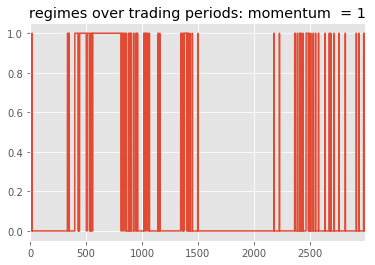

In [11]:
#daily return, monthly return, cumulative return
def return_cal(wealth_path, periods):
    cum_return =[0]
    daily_return = [0]
    for t in range(1,periods):
        c_r = (wealth_path[t] - wealth_path[0])/wealth_path[0]
        d_r = (wealth_path[t] - wealth_path[t-1])/wealth_path[t-1]
        cum_return.append(c_r)
        daily_return.append(d_r)    
    
    mon_return =[]# monthly return
    mnum = int(periods/21)+1
    for t in range(mnum):
        d1 = t*21
        d2 = (t+1)*21 
        if (d2 >= periods):        
            m_r = (wealth_path[periods-1] - wealth_path[d1])/wealth_path[d1]
        else:
            m_r = (wealth_path[d2-1] - wealth_path[d1])/wealth_path[d1]
        mon_return.append(m_r)
    return daily_return, mon_return, cum_return
 

    

#summary statitsics
def summary_stats(periods, cum_return, daily_return, risk_free):
    #compound annual return
    y = periods/252
    ret = cum_return[periods-1]
    annual_ret = (1.0+ ret)**(1./y) -1.  

    # sharpe ratio
    # daily return volatility
    r_mu = stat.mean(daily_return)
    r_std = stat.stdev(daily_return)
    sharpe_ratio = (r_mu - risk_free)/r_std
    std_annual = r_std*np.sqrt(252.)
    sharpe_annual = (annual_ret - risk_free*252)/std_annual
    return annual_ret, sharpe_ratio, r_std, sharpe_annual



#regimes history
df_regime = pd.DataFrame(signals, columns = ['regime'])
df_regime['regime'].plot(title = 'regimes over trading periods: momentum  = 1')

# summary statistics
risk_free = 0.03/252
periods = len(signals)
daily_return, mon_return, cum_return = return_cal(wealth_path, periods)    
df_cum_ret = pd.DataFrame(cum_return, columns=['cumulative return']) 
df_daily_ret =  pd.DataFrame(daily_return, columns=['daily return']) 
df_mon_ret = pd.DataFrame(mon_return, columns=['monthly returns'])
annual_ret, sharpe_ratio, r_std, sharpe_annual = summary_stats(periods, cum_return, daily_return, risk_free)

print('CAGR = ', annual_ret*100, '%  Sharpe Ratio = ', sharpe_ratio, ' daily volatility = ', r_std, 'annualized sharpe ratio', sharpe_annual)


Text(0.5,1,'monthly returns')

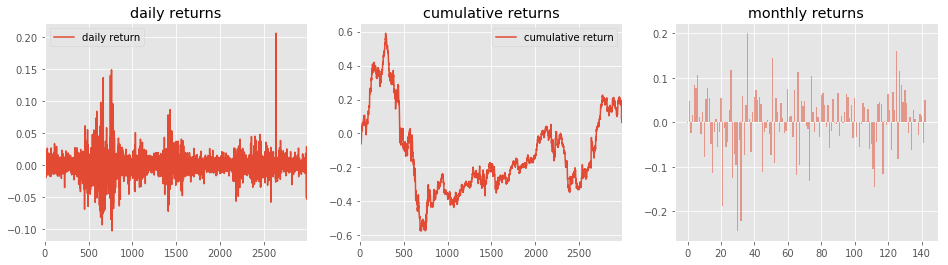

In [12]:

# plot return figures
fig = figure(figsize=[16, 4])
ax1 = fig.add_subplot(131)
df_daily_ret.plot(ax = ax1, title = 'daily returns')
ax2 = fig.add_subplot(132)
df_cum_ret.plot(ax=ax2, title='cumulative returns')
ax3 = fig.add_subplot(133)
mnum = int(periods/21)+1
x = np.arange(mnum)
plt.bar(x, mon_return,  alpha = 0.5)
plt.title('monthly returns')


In [13]:
#Comparison portfolio with pure momentum strategy 
print(periods)
mo_signals = [0] * periods
#mo_wealth_path, mo_stock_track, mo_position = macro_backtesting(mo_signals, k_mr, k_mo, data_mo, data_mr, ETF_close, tickers, tnum, bnum, t0, dates)

def pure_momentum(mo_signals, k_mr, k_mo, data_mo, data_mr, ETF_close, tickers, tnum, bnum, t0, dates):
    
        # list initialization 
    position = []  
    stock_track = []
    wealth_path = []    

    
    prices = ETF_close.iloc[t0:, :]
    regimes = ['mean_revertion', 'momentum']
    periods = len(prices)


    # first trading period
    t = 0
    wealth = 1.0e+7
    
    
     
    stocks = return_sort(data_mo, tnum, bnum)
    pl, ph = ppair(t, stocks, prices)
    pos = momentum_position(pl, ph, wealth)
    count_mo = 1
    
    position.append(pos)
    stock_track.append(stocks)
    wealth_path.append(wealth)
    df = ETF_close.iloc[t0+t,:]
    data_mo = data_mo.drop(data_mo.index[0])
    data_mo = data_mo.append(df)
    
    
    for t in range(1,periods):
        if (count_mo % k_mo == 0 ):
            stocks = stock_track[t-1]
            pos, wealth, stocks = momentum_build(t, stocks, prices, position, data_mo, tnum, bnum)
            
        else:
            pos = position[t-1]
            stocks = stock_track[t-1]
            wealth = wealth_cal(pos, stocks, t, prices)
            
        
        count_mo+=1
        position.append(pos)
        wealth_path.append(wealth)
        stock_track.append(stocks)    
        df = ETF_close.iloc[t0+t,:]
        data_mo = data_mo.drop(data_mo.index[0])
        data_mo = data_mo.append(df)
        print('t = ', t, 'regime = momentum', 'wealth = ', wealth_path[t], ' stocks = ',stock_track[t]) 
    return wealth_path, stock_track, position


mo_wealth_path, mo_stock_track, mo_position = pure_momentum(mo_signals, k_mr, k_mo, data_mo, data_mr, ETF_close, tickers, tnum, bnum, t0, dates)



2992
ret_index =  [3, 7, 1, 5, 2, 8, 4, 0, 6]  ret =  [-0.035346407938524615, -0.14356218044824498, -0.11516085483339922, -0.31369164265498006, -0.03583356561516382, -0.13406402493630909, -0.031398424806755032, -0.18673661148065623, -0.08389370507601468]
t =  1 regime = momentum wealth =  9929942.37688  stocks =  [[3, 7, 1], [4, 0, 6]]
t =  2 regime = momentum wealth =  9885152.45542  stocks =  [[3, 7, 1], [4, 0, 6]]
t =  3 regime = momentum wealth =  9813729.81007  stocks =  [[3, 7, 1], [4, 0, 6]]
t =  4 regime = momentum wealth =  9749862.51368  stocks =  [[3, 7, 1], [4, 0, 6]]
t =  5 regime = momentum wealth =  9733316.22897  stocks =  [[3, 7, 1], [4, 0, 6]]
t =  6 regime = momentum wealth =  9649925.15972  stocks =  [[3, 7, 1], [4, 0, 6]]
t =  7 regime = momentum wealth =  9541336.50373  stocks =  [[3, 7, 1], [4, 0, 6]]
t =  8 regime = momentum wealth =  9594608.73858  stocks =  [[3, 7, 1], [4, 0, 6]]
t =  9 regime = momentum wealth =  9550895.73401  stocks =  [[3, 7, 1], [4, 0, 6]

t =  171 regime = momentum wealth =  11838579.6658  stocks =  [[1, 7, 5], [2, 4, 3]]
t =  172 regime = momentum wealth =  11859718.6471  stocks =  [[1, 7, 5], [2, 4, 3]]
t =  173 regime = momentum wealth =  11822741.2354  stocks =  [[1, 7, 5], [2, 4, 3]]
t =  174 regime = momentum wealth =  11720597.8103  stocks =  [[1, 7, 5], [2, 4, 3]]
t =  175 regime = momentum wealth =  11698965.4964  stocks =  [[1, 7, 5], [2, 4, 3]]
t =  176 regime = momentum wealth =  11753434.7371  stocks =  [[1, 7, 5], [2, 4, 3]]
t =  177 regime = momentum wealth =  11782370.3998  stocks =  [[1, 7, 5], [2, 4, 3]]
t =  178 regime = momentum wealth =  11844449.6387  stocks =  [[1, 7, 5], [2, 4, 3]]
t =  179 regime = momentum wealth =  11981440.7153  stocks =  [[1, 7, 5], [2, 4, 3]]
t =  180 regime = momentum wealth =  11873637.9158  stocks =  [[1, 7, 5], [2, 4, 3]]
t =  181 regime = momentum wealth =  11645193.7235  stocks =  [[1, 7, 5], [2, 4, 3]]
t =  182 regime = momentum wealth =  11740511.4615  stocks =  [[1

t =  305 regime = momentum wealth =  12822691.0936  stocks =  [[7, 2, 0], [1, 4, 6]]
t =  306 regime = momentum wealth =  12639700.5098  stocks =  [[7, 2, 0], [1, 4, 6]]
t =  307 regime = momentum wealth =  12663856.8119  stocks =  [[7, 2, 0], [1, 4, 6]]
t =  308 regime = momentum wealth =  12467255.7763  stocks =  [[7, 2, 0], [1, 4, 6]]
t =  309 regime = momentum wealth =  12448712.9103  stocks =  [[7, 2, 0], [1, 4, 6]]
t =  310 regime = momentum wealth =  12489260.3305  stocks =  [[7, 2, 0], [1, 4, 6]]
t =  311 regime = momentum wealth =  12627697.0714  stocks =  [[7, 2, 0], [1, 4, 6]]
t =  312 regime = momentum wealth =  12582318.0792  stocks =  [[7, 2, 0], [1, 4, 6]]
t =  313 regime = momentum wealth =  12504107.8945  stocks =  [[7, 2, 0], [1, 4, 6]]
t =  314 regime = momentum wealth =  12563987.045  stocks =  [[7, 2, 0], [1, 4, 6]]
ret_index =  [7, 2, 3, 5, 0, 8, 1, 4, 6]  ret =  [-0.21627252924830098, -0.12557246450425996, -0.24014530835026715, -0.22774206636514027, -0.1223976321

t =  445 regime = momentum wealth =  8979741.02491  stocks =  [[3, 2, 8], [4, 0, 1]]
t =  446 regime = momentum wealth =  9131479.71289  stocks =  [[3, 2, 8], [4, 0, 1]]
t =  447 regime = momentum wealth =  9334217.83958  stocks =  [[3, 2, 8], [4, 0, 1]]
t =  448 regime = momentum wealth =  9310573.55246  stocks =  [[3, 2, 8], [4, 0, 1]]
t =  449 regime = momentum wealth =  9278642.81588  stocks =  [[3, 2, 8], [4, 0, 1]]
t =  450 regime = momentum wealth =  9065976.20803  stocks =  [[3, 2, 8], [4, 0, 1]]
t =  451 regime = momentum wealth =  9429723.36608  stocks =  [[3, 2, 8], [4, 0, 1]]
t =  452 regime = momentum wealth =  9158737.00736  stocks =  [[3, 2, 8], [4, 0, 1]]
t =  453 regime = momentum wealth =  9062403.28434  stocks =  [[3, 2, 8], [4, 0, 1]]
t =  454 regime = momentum wealth =  9300183.84875  stocks =  [[3, 2, 8], [4, 0, 1]]
t =  455 regime = momentum wealth =  9836909.50852  stocks =  [[3, 2, 8], [4, 0, 1]]
t =  456 regime = momentum wealth =  9823246.79997  stocks =  [[3

t =  584 regime = momentum wealth =  6950110.98957  stocks =  [[3, 8, 7], [5, 0, 1]]
t =  585 regime = momentum wealth =  7588389.31729  stocks =  [[3, 8, 7], [5, 0, 1]]
t =  586 regime = momentum wealth =  7509295.4841  stocks =  [[3, 8, 7], [5, 0, 1]]
t =  587 regime = momentum wealth =  7413931.56316  stocks =  [[3, 8, 7], [5, 0, 1]]
ret_index =  [3, 6, 7, 8, 4, 5, 2, 0, 1]  ret =  [0.30800266243807339, 0.65111549474811836, 0.23245815184862906, -0.010678553754991604, 0.10581507791442624, 0.19275955997799077, -0.0087668075014694091, 0.011461701510614875, 0.047927201222385252]
t =  588 regime = momentum wealth =  7464157.17759  stocks =  [[3, 6, 7], [2, 0, 1]]
t =  589 regime = momentum wealth =  7686759.35888  stocks =  [[3, 6, 7], [2, 0, 1]]
t =  590 regime = momentum wealth =  8166785.02471  stocks =  [[3, 6, 7], [2, 0, 1]]
t =  591 regime = momentum wealth =  8053854.8447  stocks =  [[3, 6, 7], [2, 0, 1]]
t =  592 regime = momentum wealth =  7775611.85814  stocks =  [[3, 6, 7], [2

t =  721 regime = momentum wealth =  3884366.15192  stocks =  [[4, 6, 8], [5, 7, 1]]
t =  722 regime = momentum wealth =  3851783.58495  stocks =  [[4, 6, 8], [5, 7, 1]]
t =  723 regime = momentum wealth =  3764533.19587  stocks =  [[4, 6, 8], [5, 7, 1]]
t =  724 regime = momentum wealth =  3382514.13235  stocks =  [[4, 6, 8], [5, 7, 1]]
t =  725 regime = momentum wealth =  3383573.06762  stocks =  [[4, 6, 8], [5, 7, 1]]
t =  726 regime = momentum wealth =  3175809.37247  stocks =  [[4, 6, 8], [5, 7, 1]]
t =  727 regime = momentum wealth =  3186909.21769  stocks =  [[4, 6, 8], [5, 7, 1]]
t =  728 regime = momentum wealth =  2963235.81168  stocks =  [[4, 6, 8], [5, 7, 1]]
t =  729 regime = momentum wealth =  3244823.39752  stocks =  [[4, 6, 8], [5, 7, 1]]
t =  730 regime = momentum wealth =  3184625.22245  stocks =  [[4, 6, 8], [5, 7, 1]]
t =  731 regime = momentum wealth =  3286694.90628  stocks =  [[4, 6, 8], [5, 7, 1]]
t =  732 regime = momentum wealth =  3136548.50123  stocks =  [[4

t =  872 regime = momentum wealth =  6092636.99788  stocks =  [[0, 2, 7], [8, 6, 1]]
t =  873 regime = momentum wealth =  6139132.86614  stocks =  [[0, 2, 7], [8, 6, 1]]
t =  874 regime = momentum wealth =  6106118.12492  stocks =  [[0, 2, 7], [8, 6, 1]]
t =  875 regime = momentum wealth =  6157141.99721  stocks =  [[0, 2, 7], [8, 6, 1]]
t =  876 regime = momentum wealth =  6120393.03706  stocks =  [[0, 2, 7], [8, 6, 1]]
t =  877 regime = momentum wealth =  6090057.50292  stocks =  [[0, 2, 7], [8, 6, 1]]
t =  878 regime = momentum wealth =  6085149.63337  stocks =  [[0, 2, 7], [8, 6, 1]]
t =  879 regime = momentum wealth =  6154696.77383  stocks =  [[0, 2, 7], [8, 6, 1]]
t =  880 regime = momentum wealth =  6161553.89773  stocks =  [[0, 2, 7], [8, 6, 1]]
t =  881 regime = momentum wealth =  6144604.84336  stocks =  [[0, 2, 7], [8, 6, 1]]
ret_index =  [0, 1, 7, 2, 5, 4, 3, 6, 8]  ret =  [-0.4263947515697738, -0.42154187136306687, -0.39285637363684567, -0.22151718072398929, -0.2242885925

ret_index =  [5, 0, 1, 2, 7, 4, 6, 3, 8]  ret =  [-0.36348070358478424, -0.32387891678701008, -0.30268843386224731, -0.20367075295877635, -0.26648504912254689, -0.36712272275427971, -0.24982447658725027, -0.29922751103009071, -0.19603889078432035]
t =  1008 regime = momentum wealth =  6714795.90249  stocks =  [[5, 0, 1], [6, 3, 8]]
t =  1009 regime = momentum wealth =  6709977.99529  stocks =  [[5, 0, 1], [6, 3, 8]]
t =  1010 regime = momentum wealth =  6621603.43926  stocks =  [[5, 0, 1], [6, 3, 8]]
t =  1011 regime = momentum wealth =  6572322.71913  stocks =  [[5, 0, 1], [6, 3, 8]]
t =  1012 regime = momentum wealth =  6638393.67573  stocks =  [[5, 0, 1], [6, 3, 8]]
t =  1013 regime = momentum wealth =  6660487.45813  stocks =  [[5, 0, 1], [6, 3, 8]]
t =  1014 regime = momentum wealth =  6589749.19502  stocks =  [[5, 0, 1], [6, 3, 8]]
t =  1015 regime = momentum wealth =  6519701.27676  stocks =  [[5, 0, 1], [6, 3, 8]]
t =  1016 regime = momentum wealth =  6487216.95764  stocks =  [

t =  1142 regime = momentum wealth =  7808401.73675  stocks =  [[0, 5, 8], [4, 3, 1]]
t =  1143 regime = momentum wealth =  7722120.27331  stocks =  [[0, 5, 8], [4, 3, 1]]
t =  1144 regime = momentum wealth =  7659966.16886  stocks =  [[0, 5, 8], [4, 3, 1]]
t =  1145 regime = momentum wealth =  7831773.82377  stocks =  [[0, 5, 8], [4, 3, 1]]
t =  1146 regime = momentum wealth =  7636631.73372  stocks =  [[0, 5, 8], [4, 3, 1]]
t =  1147 regime = momentum wealth =  7709895.2793  stocks =  [[0, 5, 8], [4, 3, 1]]
t =  1148 regime = momentum wealth =  7695595.53213  stocks =  [[0, 5, 8], [4, 3, 1]]
t =  1149 regime = momentum wealth =  7731765.02932  stocks =  [[0, 5, 8], [4, 3, 1]]
t =  1150 regime = momentum wealth =  7736862.27692  stocks =  [[0, 5, 8], [4, 3, 1]]
t =  1151 regime = momentum wealth =  7746779.04014  stocks =  [[0, 5, 8], [4, 3, 1]]
t =  1152 regime = momentum wealth =  7742931.51782  stocks =  [[0, 5, 8], [4, 3, 1]]
t =  1153 regime = momentum wealth =  7748360.85961  st

t =  1278 regime = momentum wealth =  8644642.96615  stocks =  [[3, 7, 5], [6, 8, 1]]
t =  1279 regime = momentum wealth =  8599620.31473  stocks =  [[3, 7, 5], [6, 8, 1]]
t =  1280 regime = momentum wealth =  8646742.70684  stocks =  [[3, 7, 5], [6, 8, 1]]
ret_index =  [3, 7, 5, 0, 2, 6, 4, 8, 1]  ret =  [-0.28864593401355498, -0.12763505484928883, -0.23258844230221698, -0.3933276889248537, -0.22689302989464855, -0.30000879474139475, -0.22720335930361146, -0.32099984251006419, -0.18238807878897778]
t =  1281 regime = momentum wealth =  8827491.70247  stocks =  [[3, 7, 5], [4, 8, 1]]
t =  1282 regime = momentum wealth =  8912018.02315  stocks =  [[3, 7, 5], [4, 8, 1]]
t =  1283 regime = momentum wealth =  8864348.24935  stocks =  [[3, 7, 5], [4, 8, 1]]
t =  1284 regime = momentum wealth =  8906826.94029  stocks =  [[3, 7, 5], [4, 8, 1]]
t =  1285 regime = momentum wealth =  8834205.1908  stocks =  [[3, 7, 5], [4, 8, 1]]
t =  1286 regime = momentum wealth =  8943858.39018  stocks =  [[3

t =  1419 regime = momentum wealth =  8745967.12185  stocks =  [[8, 4, 3], [5, 7, 1]]
t =  1420 regime = momentum wealth =  8473154.28745  stocks =  [[8, 4, 3], [5, 7, 1]]
t =  1421 regime = momentum wealth =  8540946.4309  stocks =  [[8, 4, 3], [5, 7, 1]]
t =  1422 regime = momentum wealth =  8307894.708  stocks =  [[8, 4, 3], [5, 7, 1]]
t =  1423 regime = momentum wealth =  8232701.96163  stocks =  [[8, 4, 3], [5, 7, 1]]
t =  1424 regime = momentum wealth =  7973479.33114  stocks =  [[8, 4, 3], [5, 7, 1]]
t =  1425 regime = momentum wealth =  7965738.03575  stocks =  [[8, 4, 3], [5, 7, 1]]
t =  1426 regime = momentum wealth =  8305648.11685  stocks =  [[8, 4, 3], [5, 7, 1]]
t =  1427 regime = momentum wealth =  8208042.37396  stocks =  [[8, 4, 3], [5, 7, 1]]
ret_index =  [8, 6, 4, 0, 3, 2, 5, 7, 1]  ret =  [0.00096942469666672082, 0.4165426258314473, 0.059118436777034544, 0.0389393158269149, -0.036554741477456298, 0.1255950442226188, -0.078897179949855456, 0.17242323249901403, -0.105

t =  1561 regime = momentum wealth =  9119453.74709  stocks =  [[6, 8, 0], [1, 7, 3]]
t =  1562 regime = momentum wealth =  8976595.33624  stocks =  [[6, 8, 0], [1, 7, 3]]
t =  1563 regime = momentum wealth =  9090561.30222  stocks =  [[6, 8, 0], [1, 7, 3]]
t =  1564 regime = momentum wealth =  9310766.70709  stocks =  [[6, 8, 0], [1, 7, 3]]
t =  1565 regime = momentum wealth =  9212060.2132  stocks =  [[6, 8, 0], [1, 7, 3]]
t =  1566 regime = momentum wealth =  9499941.82483  stocks =  [[6, 8, 0], [1, 7, 3]]
t =  1567 regime = momentum wealth =  9502070.47279  stocks =  [[6, 8, 0], [1, 7, 3]]
t =  1568 regime = momentum wealth =  9044519.60203  stocks =  [[6, 8, 0], [1, 7, 3]]
t =  1569 regime = momentum wealth =  9148364.26454  stocks =  [[6, 8, 0], [1, 7, 3]]
t =  1570 regime = momentum wealth =  8882115.92269  stocks =  [[6, 8, 0], [1, 7, 3]]
t =  1571 regime = momentum wealth =  8946204.23735  stocks =  [[6, 8, 0], [1, 7, 3]]
t =  1572 regime = momentum wealth =  9158674.25699  st

t =  1698 regime = momentum wealth =  9791527.95356  stocks =  [[0, 4, 6], [5, 7, 3]]
t =  1699 regime = momentum wealth =  10040439.6208  stocks =  [[0, 4, 6], [5, 7, 3]]
t =  1700 regime = momentum wealth =  10293827.2961  stocks =  [[0, 4, 6], [5, 7, 3]]
ret_index =  [1, 0, 4, 6, 5, 8, 2, 7, 3]  ret =  [-0.15000465719025113, -0.16916116613442256, -0.057710375628065358, 0.029822761737855252, -0.14880779028121027, -0.065726426975594832, -0.12092111150542784, -0.054369934292898825, -0.061123125372790299]
t =  1701 regime = momentum wealth =  10242632.3393  stocks =  [[1, 0, 4], [2, 7, 3]]
t =  1702 regime = momentum wealth =  10306494.2643  stocks =  [[1, 0, 4], [2, 7, 3]]
t =  1703 regime = momentum wealth =  10235284.3472  stocks =  [[1, 0, 4], [2, 7, 3]]
t =  1704 regime = momentum wealth =  10217334.4204  stocks =  [[1, 0, 4], [2, 7, 3]]
t =  1705 regime = momentum wealth =  10223014.3418  stocks =  [[1, 0, 4], [2, 7, 3]]
t =  1706 regime = momentum wealth =  10263183.6209  stocks 

t =  1840 regime = momentum wealth =  10078898.2055  stocks =  [[1, 0, 4], [7, 8, 2]]
t =  1841 regime = momentum wealth =  10185757.7387  stocks =  [[1, 0, 4], [7, 8, 2]]
t =  1842 regime = momentum wealth =  10174334.3645  stocks =  [[1, 0, 4], [7, 8, 2]]
t =  1843 regime = momentum wealth =  10267095.5525  stocks =  [[1, 0, 4], [7, 8, 2]]
t =  1844 regime = momentum wealth =  10316017.7398  stocks =  [[1, 0, 4], [7, 8, 2]]
t =  1845 regime = momentum wealth =  10197950.8653  stocks =  [[1, 0, 4], [7, 8, 2]]
t =  1846 regime = momentum wealth =  10249937.857  stocks =  [[1, 0, 4], [7, 8, 2]]
t =  1847 regime = momentum wealth =  10285063.9843  stocks =  [[1, 0, 4], [7, 8, 2]]
ret_index =  [1, 0, 4, 5, 6, 3, 7, 8, 2]  ret =  [-0.26288852444352684, -0.28526336442292655, -0.04936667291421204, -0.14108200936267445, -0.25985652221931566, -0.24139078367460842, -0.17926854636255163, -0.12537318901937544, -0.12474097181517618]
t =  1848 regime = momentum wealth =  10253950.0665  stocks =  [[

t =  1975 regime = momentum wealth =  10561192.9004  stocks =  [[4, 5, 0], [3, 6, 8]]
t =  1976 regime = momentum wealth =  10649237.0104  stocks =  [[4, 5, 0], [3, 6, 8]]
t =  1977 regime = momentum wealth =  10664462.2539  stocks =  [[4, 5, 0], [3, 6, 8]]
t =  1978 regime = momentum wealth =  10706349.0884  stocks =  [[4, 5, 0], [3, 6, 8]]
t =  1979 regime = momentum wealth =  10836012.1383  stocks =  [[4, 5, 0], [3, 6, 8]]
t =  1980 regime = momentum wealth =  10771763.9587  stocks =  [[4, 5, 0], [3, 6, 8]]
t =  1981 regime = momentum wealth =  10881713.5494  stocks =  [[4, 5, 0], [3, 6, 8]]
t =  1982 regime = momentum wealth =  11007488.0776  stocks =  [[4, 5, 0], [3, 6, 8]]
t =  1983 regime = momentum wealth =  10987959.8687  stocks =  [[4, 5, 0], [3, 6, 8]]
t =  1984 regime = momentum wealth =  11027341.0568  stocks =  [[4, 5, 0], [3, 6, 8]]
t =  1985 regime = momentum wealth =  11076329.166  stocks =  [[4, 5, 0], [3, 6, 8]]
t =  1986 regime = momentum wealth =  11005691.2253  st

t =  2122 regime = momentum wealth =  13128154.757  stocks =  [[4, 2, 7], [5, 0, 6]]
t =  2123 regime = momentum wealth =  13028042.2055  stocks =  [[4, 2, 7], [5, 0, 6]]
t =  2124 regime = momentum wealth =  12970921.7821  stocks =  [[4, 2, 7], [5, 0, 6]]
t =  2125 regime = momentum wealth =  12993146.2863  stocks =  [[4, 2, 7], [5, 0, 6]]
t =  2126 regime = momentum wealth =  13012574.7873  stocks =  [[4, 2, 7], [5, 0, 6]]
t =  2127 regime = momentum wealth =  12967221.9351  stocks =  [[4, 2, 7], [5, 0, 6]]
t =  2128 regime = momentum wealth =  13002684.9432  stocks =  [[4, 2, 7], [5, 0, 6]]
t =  2129 regime = momentum wealth =  13048674.8054  stocks =  [[4, 2, 7], [5, 0, 6]]
t =  2130 regime = momentum wealth =  13021374.7013  stocks =  [[4, 2, 7], [5, 0, 6]]
t =  2131 regime = momentum wealth =  13030146.0387  stocks =  [[4, 2, 7], [5, 0, 6]]
t =  2132 regime = momentum wealth =  13053872.3586  stocks =  [[4, 2, 7], [5, 0, 6]]
t =  2133 regime = momentum wealth =  12873124.2349  st

t =  2253 regime = momentum wealth =  12509274.3836  stocks =  [[4, 0, 2], [7, 8, 3]]
t =  2254 regime = momentum wealth =  12406376.1886  stocks =  [[4, 0, 2], [7, 8, 3]]
t =  2255 regime = momentum wealth =  12855094.9926  stocks =  [[4, 0, 2], [7, 8, 3]]
t =  2256 regime = momentum wealth =  12485848.6291  stocks =  [[4, 0, 2], [7, 8, 3]]
t =  2257 regime = momentum wealth =  12634609.9507  stocks =  [[4, 0, 2], [7, 8, 3]]
t =  2258 regime = momentum wealth =  12630340.7543  stocks =  [[4, 0, 2], [7, 8, 3]]
t =  2259 regime = momentum wealth =  12523639.304  stocks =  [[4, 0, 2], [7, 8, 3]]
t =  2260 regime = momentum wealth =  12698064.3014  stocks =  [[4, 0, 2], [7, 8, 3]]
t =  2261 regime = momentum wealth =  12667400.0114  stocks =  [[4, 0, 2], [7, 8, 3]]
t =  2262 regime = momentum wealth =  12589894.0846  stocks =  [[4, 0, 2], [7, 8, 3]]
t =  2263 regime = momentum wealth =  12851847.7669  stocks =  [[4, 0, 2], [7, 8, 3]]
t =  2264 regime = momentum wealth =  12858014.6324  st

t =  2397 regime = momentum wealth =  11365143.1441  stocks =  [[0, 6, 4], [5, 7, 3]]
t =  2398 regime = momentum wealth =  11310062.5543  stocks =  [[0, 6, 4], [5, 7, 3]]
t =  2399 regime = momentum wealth =  11117420.2734  stocks =  [[0, 6, 4], [5, 7, 3]]
t =  2400 regime = momentum wealth =  11020869.0352  stocks =  [[0, 6, 4], [5, 7, 3]]
t =  2401 regime = momentum wealth =  11147717.3253  stocks =  [[0, 6, 4], [5, 7, 3]]
t =  2402 regime = momentum wealth =  11220478.6721  stocks =  [[0, 6, 4], [5, 7, 3]]
t =  2403 regime = momentum wealth =  11112068.8016  stocks =  [[0, 6, 4], [5, 7, 3]]
t =  2404 regime = momentum wealth =  10877675.0897  stocks =  [[0, 6, 4], [5, 7, 3]]
t =  2405 regime = momentum wealth =  11020550.7042  stocks =  [[0, 6, 4], [5, 7, 3]]
t =  2406 regime = momentum wealth =  10914386.0447  stocks =  [[0, 6, 4], [5, 7, 3]]
t =  2407 regime = momentum wealth =  11344964.8887  stocks =  [[0, 6, 4], [5, 7, 3]]
t =  2408 regime = momentum wealth =  11329782.6199  s

t =  2533 regime = momentum wealth =  12352868.5321  stocks =  [[8, 6, 0], [1, 7, 3]]
t =  2534 regime = momentum wealth =  12589034.7479  stocks =  [[8, 6, 0], [1, 7, 3]]
t =  2535 regime = momentum wealth =  12753555.604  stocks =  [[8, 6, 0], [1, 7, 3]]
t =  2536 regime = momentum wealth =  12520019.0675  stocks =  [[8, 6, 0], [1, 7, 3]]
t =  2537 regime = momentum wealth =  12386563.234  stocks =  [[8, 6, 0], [1, 7, 3]]
t =  2538 regime = momentum wealth =  12353029.3581  stocks =  [[8, 6, 0], [1, 7, 3]]
t =  2539 regime = momentum wealth =  11984588.9925  stocks =  [[8, 6, 0], [1, 7, 3]]
t =  2540 regime = momentum wealth =  11700389.8412  stocks =  [[8, 6, 0], [1, 7, 3]]
ret_index =  [8, 6, 0, 5, 2, 7, 1, 4, 3]  ret =  [-0.058895331613836865, 0.044664298532084867, -0.032286294540697313, 0.14595407706229446, 0.068113251875451697, -0.045363538906772138, -0.13519227088527408, 0.036561164677317626, -0.20760532408733068]
t =  2541 regime = momentum wealth =  11759664.9962  stocks =  [

t =  2668 regime = momentum wealth =  14347705.6818  stocks =  [[1, 3, 8], [6, 0, 4]]
t =  2669 regime = momentum wealth =  14365388.8391  stocks =  [[1, 3, 8], [6, 0, 4]]
t =  2670 regime = momentum wealth =  14685963.9687  stocks =  [[1, 3, 8], [6, 0, 4]]
t =  2671 regime = momentum wealth =  14747307.6496  stocks =  [[1, 3, 8], [6, 0, 4]]
t =  2672 regime = momentum wealth =  14876572.4061  stocks =  [[1, 3, 8], [6, 0, 4]]
t =  2673 regime = momentum wealth =  14671856.9186  stocks =  [[1, 3, 8], [6, 0, 4]]
t =  2674 regime = momentum wealth =  14660010.2431  stocks =  [[1, 3, 8], [6, 0, 4]]
t =  2675 regime = momentum wealth =  14455813.3755  stocks =  [[1, 3, 8], [6, 0, 4]]
t =  2676 regime = momentum wealth =  14370426.4309  stocks =  [[1, 3, 8], [6, 0, 4]]
t =  2677 regime = momentum wealth =  14531841.4975  stocks =  [[1, 3, 8], [6, 0, 4]]
t =  2678 regime = momentum wealth =  14636970.276  stocks =  [[1, 3, 8], [6, 0, 4]]
t =  2679 regime = momentum wealth =  14456208.6157  st

t =  2805 regime = momentum wealth =  16260290.0633  stocks =  [[1, 2, 5], [6, 8, 3]]
t =  2806 regime = momentum wealth =  16280966.3986  stocks =  [[1, 2, 5], [6, 8, 3]]
t =  2807 regime = momentum wealth =  16160531.6822  stocks =  [[1, 2, 5], [6, 8, 3]]
t =  2808 regime = momentum wealth =  16216816.4163  stocks =  [[1, 2, 5], [6, 8, 3]]
t =  2809 regime = momentum wealth =  16121887.0477  stocks =  [[1, 2, 5], [6, 8, 3]]
t =  2810 regime = momentum wealth =  16206482.8597  stocks =  [[1, 2, 5], [6, 8, 3]]
t =  2811 regime = momentum wealth =  16325709.5067  stocks =  [[1, 2, 5], [6, 8, 3]]
t =  2812 regime = momentum wealth =  16199729.7103  stocks =  [[1, 2, 5], [6, 8, 3]]
t =  2813 regime = momentum wealth =  16200603.1957  stocks =  [[1, 2, 5], [6, 8, 3]]
ret_index =  [1, 2, 5, 0, 7, 6, 8, 4, 3]  ret =  [-0.14475037212321185, -0.42735172538258959, -0.23173888683295085, 0.006254541580316797, -0.045911901108728226, -0.18170866076036807, -0.07959396563119614, -0.11819442037124428,

In [23]:
#Comparison portfolio with pure mean reversion strategy
print(periods)
mr_signals = [1] * periods
#mr_wealth_path, mr_stock_track, mr_position = macro_backtesting(mr_signals, k_mr, k_mo, data_mo, data_mr, ETF_close, tickers, tnum, bnum, t0, dates)

def pure_mean_reversion(mr_signals, k_mr, k_mo, data_mo, data_mr, ETF_close, tickers, tnum, bnum, t0, dates):
    
        # list initialization 
    position = []  
    stock_track = []
    wealth_path = []    

    
    prices = ETF_close.iloc[t0:, :]
    regimes = ['mean_revertion', 'momentum']
    periods = len(prices)


    # first trading period
    t = 0
    wealth = 1.0e+7
    
    
    regime_state = 0
    stocks = return_sort(data_mr, tnum, bnum)
    pl, ph = ppair(t, stocks, prices)
    pos = mean_revert_position(wealth, pl, ph)
    count_mr = 1
    
    print(stocks)
    print(' pl = ', pl, ' ph = ', ph, ' pos = ', pos)
    
    position.append(pos)
    stock_track.append(stocks)
    wealth_path.append(wealth)
    df = ETF_close.iloc[t0+t,:]
    data_mr = data_mr.drop(data_mr.index[0])
    data_mr = data_mr.append(df)
    fmt.display(data_mr)
    
    
    
    for t in range(1,periods):
        if (count_mr % k_mr == 0 ):
            stocks = stock_track[t-1]
            pos, wealth, stocks = mean_reversion_build(t, stocks, prices, position, data_mr, tnum, bnum)
                    
        else:                 
            stocks = stock_track[t-1]
            pos = position[t-1]
            wealth = wealth_cal(pos, stocks, t, prices)
        count_mr +=1
        
        position.append(pos)
        wealth_path.append(wealth)
        stock_track.append(stocks)    
        df = ETF_close.iloc[t0+t,:]
        data_mr = data_mr.drop(data_mr.index[0])
        data_mr = data_mr.append(df)
        print('t = ', dates[t], 'regime = mean reversion', 'wealth = ', wealth_path[t]) 
    return wealth_path, stock_track, position


mr_wealth_path, mr_stock_track, mr_position = pure_mean_reversion(mr_signals, k_mr, k_mo, data_mo, data_mr, ETF_close, tickers, tnum, bnum, t0, dates)


2992
[[5, 7, 3], [1, 4, 8]]
 pl =  [26.441586999999998, 24.662656999999999, 43.109734000000003]  ph =  [15.970018, 26.074421000000001, 20.011536]  pos =  [[252128.08394090217, 270314.21094112721, 154644.11510093443], [-208724.45687495993, -127839.20813939966, -166570.58875107506]]


,XLY,XLF,XLK,XLE,XLV,XLI,XLP,XLB,XLU
Date,,,,,,,,,
2006-03-03,28.153332,15.870179,18.393534,42.769047,26.298046,25.516483,17.241371,24.079582,20.809443
2006-03-06,27.976746,15.821379,18.318281,41.283627,26.159893,25.383989,17.182800,23.753353,20.474436
2006-03-07,27.850607,15.875064,18.201233,40.675247,26.168022,25.399578,17.299944,23.525759,20.377796
2006-03-08,27.901072,15.884820,18.184521,40.675247,26.346804,25.368395,17.490292,23.381615,20.358467
2006-03-09,27.791744,15.787219,18.075830,40.382885,26.257418,25.337233,17.519575,23.336100,20.300478
2006-03-10,28.052431,15.928744,18.159433,40.604122,26.354933,25.602211,17.680643,23.753353,20.429333
2006-03-13,28.044024,15.933621,18.226313,41.402153,26.338676,25.586626,17.695288,23.806459,20.455105
2006-03-14,28.346739,16.119070,18.435331,42.168556,26.525591,25.828234,17.651360,24.246479,20.674154
2006-03-15,28.506510,16.138588,18.544025,42.389793,26.614988,26.217915,17.585466,24.534771,20.809443


t =  2006-04-03 00:00:00 regime = mean reversion wealth =  10135504.6711
t =  2006-04-04 00:00:00 regime = mean reversion wealth =  10203715.9019
t =  2006-04-05 00:00:00 regime = mean reversion wealth =  10383762.5052
t =  2006-04-06 00:00:00 regime = mean reversion wealth =  10482498.2083
t =  2006-04-07 00:00:00 regime = mean reversion wealth =  10328000.21
t =  2006-04-10 00:00:00 regime = mean reversion wealth =  10432128.6656
t =  2006-04-11 00:00:00 regime = mean reversion wealth =  10423772.0934
t =  2006-04-12 00:00:00 regime = mean reversion wealth =  10432506.4109
t =  2006-04-13 00:00:00 regime = mean reversion wealth =  10479297.8793
t =  2006-04-17 00:00:00 regime = mean reversion wealth =  10656833.3404
t =  2006-04-18 00:00:00 regime = mean reversion wealth =  11060496.6051
t =  2006-04-19 00:00:00 regime = mean reversion wealth =  11272909.7686
t =  2006-04-20 00:00:00 regime = mean reversion wealth =  11091422.3458
t =  2006-04-21 00:00:00 regime = mean reversion weal

t =  2007-03-28 00:00:00 regime = mean reversion wealth =  12858030.5288
t =  2007-03-29 00:00:00 regime = mean reversion wealth =  12988357.2966
t =  2007-03-30 00:00:00 regime = mean reversion wealth =  12782324.4106
t =  2007-04-02 00:00:00 regime = mean reversion wealth =  13069510.4811
t =  2007-04-03 00:00:00 regime = mean reversion wealth =  13073953.671
t =  2007-04-04 00:00:00 regime = mean reversion wealth =  13049891.1299
t =  2007-04-05 00:00:00 regime = mean reversion wealth =  13066365.2817
t =  2007-04-09 00:00:00 regime = mean reversion wealth =  13233667.4786
t =  2007-04-10 00:00:00 regime = mean reversion wealth =  13236553.3071
t =  2007-04-11 00:00:00 regime = mean reversion wealth =  13211780.8481
t =  2007-04-12 00:00:00 regime = mean reversion wealth =  13311125.7791
t =  2007-04-13 00:00:00 regime = mean reversion wealth =  13247505.8524
t =  2007-04-16 00:00:00 regime = mean reversion wealth =  13276998.0097
t =  2007-04-17 00:00:00 regime = mean reversion wea

t =  2008-01-17 00:00:00 regime = mean reversion wealth =  12732396.314
t =  2008-01-18 00:00:00 regime = mean reversion wealth =  12601084.4611
t =  2008-01-22 00:00:00 regime = mean reversion wealth =  11725138.6839
t =  2008-01-23 00:00:00 regime = mean reversion wealth =  11756293.1527
t =  2008-01-24 00:00:00 regime = mean reversion wealth =  11652324.6501
t =  2008-01-25 00:00:00 regime = mean reversion wealth =  11460875.1911
t =  2008-01-28 00:00:00 regime = mean reversion wealth =  11724092.4445
t =  2008-01-29 00:00:00 regime = mean reversion wealth =  11778806.2997
t =  2008-01-30 00:00:00 regime = mean reversion wealth =  11572693.5549
t =  2008-01-31 00:00:00 regime = mean reversion wealth =  12278737.475
t =  2008-02-01 00:00:00 regime = mean reversion wealth =  12271295.6666
t =  2008-02-04 00:00:00 regime = mean reversion wealth =  11968115.6043
t =  2008-02-05 00:00:00 regime = mean reversion wealth =  11658958.4401
t =  2008-02-06 00:00:00 regime = mean reversion weal

t =  2008-10-24 00:00:00 regime = mean reversion wealth =  10022883.5612
t =  2008-10-27 00:00:00 regime = mean reversion wealth =  9889472.22571
t =  2008-10-28 00:00:00 regime = mean reversion wealth =  10515576.5404
t =  2008-10-29 00:00:00 regime = mean reversion wealth =  9604405.3321
t =  2008-10-30 00:00:00 regime = mean reversion wealth =  10036325.5735
t =  2008-10-31 00:00:00 regime = mean reversion wealth =  9578542.23708
t =  2008-11-03 00:00:00 regime = mean reversion wealth =  10017678.6629
t =  2008-11-04 00:00:00 regime = mean reversion wealth =  9827262.34346
t =  2008-11-05 00:00:00 regime = mean reversion wealth =  9976934.10334
t =  2008-11-06 00:00:00 regime = mean reversion wealth =  9991186.45521
t =  2008-11-07 00:00:00 regime = mean reversion wealth =  10125506.275
t =  2008-11-10 00:00:00 regime = mean reversion wealth =  9999173.86717
t =  2008-11-11 00:00:00 regime = mean reversion wealth =  10062975.234
t =  2008-11-12 00:00:00 regime = mean reversion wealt

t =  2009-08-14 00:00:00 regime = mean reversion wealth =  15630695.8349
t =  2009-08-17 00:00:00 regime = mean reversion wealth =  14629827.2578
t =  2009-08-18 00:00:00 regime = mean reversion wealth =  15002423.2414
t =  2009-08-19 00:00:00 regime = mean reversion wealth =  15072302.6703
t =  2009-08-20 00:00:00 regime = mean reversion wealth =  15351189.0533
t =  2009-08-21 00:00:00 regime = mean reversion wealth =  15851849.5328
t =  2009-08-24 00:00:00 regime = mean reversion wealth =  15716517.9131
t =  2009-08-25 00:00:00 regime = mean reversion wealth =  15862679.4413
t =  2009-08-26 00:00:00 regime = mean reversion wealth =  15657123.2577
t =  2009-08-27 00:00:00 regime = mean reversion wealth =  15919172.5961
t =  2009-08-28 00:00:00 regime = mean reversion wealth =  15955602.863
t =  2009-08-31 00:00:00 regime = mean reversion wealth =  15760189.6571
t =  2009-09-01 00:00:00 regime = mean reversion wealth =  15004849.8794
t =  2009-09-02 00:00:00 regime = mean reversion wea

t =  2010-05-20 00:00:00 regime = mean reversion wealth =  16848033.3603
t =  2010-05-21 00:00:00 regime = mean reversion wealth =  16673010.5517
t =  2010-05-24 00:00:00 regime = mean reversion wealth =  16705875.8339
t =  2010-05-25 00:00:00 regime = mean reversion wealth =  16353848.2812
t =  2010-05-26 00:00:00 regime = mean reversion wealth =  16395668.8592
t =  2010-05-27 00:00:00 regime = mean reversion wealth =  16499485.9029
t =  2010-05-28 00:00:00 regime = mean reversion wealth =  16641139.7418
t =  2010-06-01 00:00:00 regime = mean reversion wealth =  16671336.3105
t =  2010-06-02 00:00:00 regime = mean reversion wealth =  16801889.422
t =  2010-06-03 00:00:00 regime = mean reversion wealth =  17013810.8037
t =  2010-06-04 00:00:00 regime = mean reversion wealth =  16602596.5546
t =  2010-06-07 00:00:00 regime = mean reversion wealth =  16445730.1781
t =  2010-06-08 00:00:00 regime = mean reversion wealth =  16477126.2672
t =  2010-06-09 00:00:00 regime = mean reversion wea

t =  2010-11-01 00:00:00 regime = mean reversion wealth =  17265127.1601
t =  2010-11-02 00:00:00 regime = mean reversion wealth =  17495983.5225
t =  2010-11-03 00:00:00 regime = mean reversion wealth =  17597480.2015
t =  2010-11-04 00:00:00 regime = mean reversion wealth =  18039285.5676
t =  2010-11-05 00:00:00 regime = mean reversion wealth =  18046779.3303
t =  2010-11-08 00:00:00 regime = mean reversion wealth =  18166954.606
t =  2010-11-09 00:00:00 regime = mean reversion wealth =  18077557.6973
t =  2010-11-10 00:00:00 regime = mean reversion wealth =  18395834.1445
t =  2010-11-11 00:00:00 regime = mean reversion wealth =  18311828.5194
t =  2010-11-12 00:00:00 regime = mean reversion wealth =  17988524.4575
t =  2010-11-15 00:00:00 regime = mean reversion wealth =  17844595.5982
t =  2010-11-16 00:00:00 regime = mean reversion wealth =  17466768.3284
t =  2010-11-17 00:00:00 regime = mean reversion wealth =  17613209.1104
t =  2010-11-18 00:00:00 regime = mean reversion wea

t =  2011-08-16 00:00:00 regime = mean reversion wealth =  19859732.1741
t =  2011-08-17 00:00:00 regime = mean reversion wealth =  19947198.4122
t =  2011-08-18 00:00:00 regime = mean reversion wealth =  19986348.7414
t =  2011-08-19 00:00:00 regime = mean reversion wealth =  19865438.515
t =  2011-08-22 00:00:00 regime = mean reversion wealth =  19990661.7733
t =  2011-08-23 00:00:00 regime = mean reversion wealth =  20309936.9354
t =  2011-08-24 00:00:00 regime = mean reversion wealth =  20381927.6791
t =  2011-08-25 00:00:00 regime = mean reversion wealth =  20015226.958
t =  2011-08-26 00:00:00 regime = mean reversion wealth =  19948412.2073
t =  2011-08-29 00:00:00 regime = mean reversion wealth =  20099857.1888
t =  2011-08-30 00:00:00 regime = mean reversion wealth =  20137407.4264
t =  2011-08-31 00:00:00 regime = mean reversion wealth =  20175713.067
t =  2011-09-01 00:00:00 regime = mean reversion wealth =  20275911.4351
t =  2011-09-02 00:00:00 regime = mean reversion wealt

t =  2012-05-22 00:00:00 regime = mean reversion wealth =  24176093.2593
t =  2012-05-23 00:00:00 regime = mean reversion wealth =  23856087.4249
t =  2012-05-24 00:00:00 regime = mean reversion wealth =  24208264.9119
t =  2012-05-25 00:00:00 regime = mean reversion wealth =  24283743.2782
t =  2012-05-29 00:00:00 regime = mean reversion wealth =  24110056.7399
t =  2012-05-30 00:00:00 regime = mean reversion wealth =  24373890.4599
t =  2012-05-31 00:00:00 regime = mean reversion wealth =  24380059.7625
t =  2012-06-01 00:00:00 regime = mean reversion wealth =  24400839.4648
t =  2012-06-04 00:00:00 regime = mean reversion wealth =  24617361.5636
t =  2012-06-05 00:00:00 regime = mean reversion wealth =  24476877.3328
t =  2012-06-06 00:00:00 regime = mean reversion wealth =  24496149.2287
t =  2012-06-07 00:00:00 regime = mean reversion wealth =  24675569.0791
t =  2012-06-08 00:00:00 regime = mean reversion wealth =  24793921.9015
t =  2012-06-11 00:00:00 regime = mean reversion we

t =  2013-03-06 00:00:00 regime = mean reversion wealth =  30974603.9112
t =  2013-03-07 00:00:00 regime = mean reversion wealth =  30791226.0659
t =  2013-03-08 00:00:00 regime = mean reversion wealth =  30911560.3562
t =  2013-03-11 00:00:00 regime = mean reversion wealth =  30964206.1332
t =  2013-03-12 00:00:00 regime = mean reversion wealth =  30786588.3666
t =  2013-03-13 00:00:00 regime = mean reversion wealth =  31089525.7088
t =  2013-03-14 00:00:00 regime = mean reversion wealth =  31021315.5737
t =  2013-03-15 00:00:00 regime = mean reversion wealth =  31126190.5144
t =  2013-03-18 00:00:00 regime = mean reversion wealth =  30784263.4413
t =  2013-03-19 00:00:00 regime = mean reversion wealth =  30711112.6053
t =  2013-03-20 00:00:00 regime = mean reversion wealth =  31067483.6042
t =  2013-03-21 00:00:00 regime = mean reversion wealth =  30876450.0892
t =  2013-03-22 00:00:00 regime = mean reversion wealth =  31251321.7088
t =  2013-03-25 00:00:00 regime = mean reversion we

t =  2013-12-13 00:00:00 regime = mean reversion wealth =  34532521.3614
t =  2013-12-16 00:00:00 regime = mean reversion wealth =  34708189.3747
t =  2013-12-17 00:00:00 regime = mean reversion wealth =  34525918.5778
t =  2013-12-18 00:00:00 regime = mean reversion wealth =  35453075.8571
t =  2013-12-19 00:00:00 regime = mean reversion wealth =  35428671.3028
t =  2013-12-20 00:00:00 regime = mean reversion wealth =  35599017.3888
t =  2013-12-23 00:00:00 regime = mean reversion wealth =  35947923.6944
t =  2013-12-24 00:00:00 regime = mean reversion wealth =  35870748.844
t =  2013-12-26 00:00:00 regime = mean reversion wealth =  36199120.0888
t =  2013-12-27 00:00:00 regime = mean reversion wealth =  35923189.8438
t =  2013-12-30 00:00:00 regime = mean reversion wealth =  36053096.3584
t =  2013-12-31 00:00:00 regime = mean reversion wealth =  36411600.7431
t =  2014-01-02 00:00:00 regime = mean reversion wealth =  36043240.2188
t =  2014-01-03 00:00:00 regime = mean reversion wea

t =  2014-08-20 00:00:00 regime = mean reversion wealth =  37103931.5346
t =  2014-08-21 00:00:00 regime = mean reversion wealth =  37055335.4431
t =  2014-08-22 00:00:00 regime = mean reversion wealth =  37192140.4054
t =  2014-08-25 00:00:00 regime = mean reversion wealth =  37304852.1442
t =  2014-08-26 00:00:00 regime = mean reversion wealth =  37550449.8443
t =  2014-08-27 00:00:00 regime = mean reversion wealth =  37454132.7217
t =  2014-08-28 00:00:00 regime = mean reversion wealth =  37358589.6449
t =  2014-08-29 00:00:00 regime = mean reversion wealth =  37344690.3875
t =  2014-09-02 00:00:00 regime = mean reversion wealth =  37527906.571
t =  2014-09-03 00:00:00 regime = mean reversion wealth =  37537885.1213
t =  2014-09-04 00:00:00 regime = mean reversion wealth =  37618828.0714
t =  2014-09-05 00:00:00 regime = mean reversion wealth =  37665793.1492
t =  2014-09-08 00:00:00 regime = mean reversion wealth =  37881437.3136
t =  2014-09-09 00:00:00 regime = mean reversion wea

t =  2015-03-09 00:00:00 regime = mean reversion wealth =  39422249.7686
t =  2015-03-10 00:00:00 regime = mean reversion wealth =  38442041.8261
t =  2015-03-11 00:00:00 regime = mean reversion wealth =  38290234.1186
t =  2015-03-12 00:00:00 regime = mean reversion wealth =  38875164.8035
t =  2015-03-13 00:00:00 regime = mean reversion wealth =  38748060.9487
t =  2015-03-16 00:00:00 regime = mean reversion wealth =  39371162.8189
t =  2015-03-17 00:00:00 regime = mean reversion wealth =  39259204.5129
t =  2015-03-18 00:00:00 regime = mean reversion wealth =  39384456.1136
t =  2015-03-19 00:00:00 regime = mean reversion wealth =  39882366.9323
t =  2015-03-20 00:00:00 regime = mean reversion wealth =  40049995.6931
t =  2015-03-23 00:00:00 regime = mean reversion wealth =  40041343.2614
t =  2015-03-24 00:00:00 regime = mean reversion wealth =  39925498.9801
t =  2015-03-25 00:00:00 regime = mean reversion wealth =  38531948.2309
t =  2015-03-26 00:00:00 regime = mean reversion we

t =  2015-12-17 00:00:00 regime = mean reversion wealth =  38603589.1159
t =  2015-12-18 00:00:00 regime = mean reversion wealth =  37929800.6041
t =  2015-12-21 00:00:00 regime = mean reversion wealth =  38225323.2215
t =  2015-12-22 00:00:00 regime = mean reversion wealth =  38481687.3867
t =  2015-12-23 00:00:00 regime = mean reversion wealth =  38317388.6904
t =  2015-12-24 00:00:00 regime = mean reversion wealth =  38477494.0203
t =  2015-12-28 00:00:00 regime = mean reversion wealth =  38656705.0566
t =  2015-12-29 00:00:00 regime = mean reversion wealth =  38976459.2114
t =  2015-12-30 00:00:00 regime = mean reversion wealth =  39144166.347
t =  2015-12-31 00:00:00 regime = mean reversion wealth =  38535314.825
t =  2016-01-04 00:00:00 regime = mean reversion wealth =  38120652.4178
t =  2016-01-05 00:00:00 regime = mean reversion wealth =  38557948.7544
t =  2016-01-06 00:00:00 regime = mean reversion wealth =  39145296.0876
t =  2016-01-07 00:00:00 regime = mean reversion weal

t =  2016-10-17 00:00:00 regime = mean reversion wealth =  42054028.3754
t =  2016-10-18 00:00:00 regime = mean reversion wealth =  42336620.4886
t =  2016-10-19 00:00:00 regime = mean reversion wealth =  42780087.7607
t =  2016-10-20 00:00:00 regime = mean reversion wealth =  42622397.4836
t =  2016-10-21 00:00:00 regime = mean reversion wealth =  42928975.2518
t =  2016-10-24 00:00:00 regime = mean reversion wealth =  43319263.1184
t =  2016-10-25 00:00:00 regime = mean reversion wealth =  42955004.3037
t =  2016-10-26 00:00:00 regime = mean reversion wealth =  43104795.6861
t =  2016-10-27 00:00:00 regime = mean reversion wealth =  43121088.0168
t =  2016-10-28 00:00:00 regime = mean reversion wealth =  43086630.1669
t =  2016-10-31 00:00:00 regime = mean reversion wealth =  42481858.8438
t =  2016-11-01 00:00:00 regime = mean reversion wealth =  42529656.5717
t =  2016-11-02 00:00:00 regime = mean reversion wealth =  42136170.6471
t =  2016-11-03 00:00:00 regime = mean reversion we

t =  2017-04-18 00:00:00 regime = mean reversion wealth =  50602681.0188
t =  2017-04-19 00:00:00 regime = mean reversion wealth =  50285028.8273
t =  2017-04-20 00:00:00 regime = mean reversion wealth =  49768149.7371
t =  2017-04-21 00:00:00 regime = mean reversion wealth =  49941598.4511
t =  2017-04-24 00:00:00 regime = mean reversion wealth =  49821325.9089
t =  2017-04-25 00:00:00 regime = mean reversion wealth =  49664846.3816
t =  2017-04-26 00:00:00 regime = mean reversion wealth =  49464771.9571
t =  2017-04-27 00:00:00 regime = mean reversion wealth =  49848913.2465
t =  2017-04-28 00:00:00 regime = mean reversion wealth =  49931969.4833
t =  2017-05-01 00:00:00 regime = mean reversion wealth =  49582441.2586
t =  2017-05-02 00:00:00 regime = mean reversion wealth =  49343786.3416
t =  2017-05-03 00:00:00 regime = mean reversion wealth =  48809327.3617
t =  2017-05-04 00:00:00 regime = mean reversion wealth =  49168766.4236
t =  2017-05-05 00:00:00 regime = mean reversion we

In [23]:

#comparison of strategies performance

#summary statistics for pure momentun strategy
mo_daily_return, mo_mon_return, mo_cum_return = return_cal(mo_wealth_path, periods)    
mo_df_cum_ret = pd.DataFrame(mo_cum_return, columns=['mo_cumulative return']) 
mo_df_daily_ret =  pd.DataFrame(mo_daily_return, columns=['mo_daily return']) 
mo_df_mon_ret = pd.DataFrame(mo_mon_return, columns=['mo_monthly returns'])
mo_annual_ret, mo_sharpe_ratio, mo_r_std, mo_sharpe_annual = summary_stats(periods, mo_cum_return, mo_daily_return, risk_free)

#summary statistics for pure mean reversion strategy
mr_daily_return, mr_mon_return, mr_cum_return = return_cal(mr_wealth_path, periods)    
mr_df_cum_ret = pd.DataFrame(mr_cum_return, columns=['mr_cumulative return']) 
mr_df_daily_ret =  pd.DataFrame(mr_daily_return, columns=['mr_daily return']) 
mr_df_mon_ret = pd.DataFrame(mr_mon_return, columns=['mr_monthly returns'])
mr_annual_ret, mr_sharpe_ratio, mr_r_std, mr_sharpe_annual = summary_stats(periods, mr_cum_return, mr_daily_return, risk_free)



print('\ntwo_regimes_switch :    CAGR = ', annual_ret*100, '%  Sharpe Ratio = ', sharpe_ratio, ' daily volatility = ', r_std, 'annualized sharpe ratio', sharpe_annual)
print('pure_mean_reversion :   CAGR = ', mr_annual_ret*100, '%  Sharpe Ratio = ', mr_sharpe_ratio, ' daily volatility = ', mr_r_std, 'annualized sharpe ratio', mr_sharpe_annual)
print('pure_momentum :         CAGR = ', mo_annual_ret*100, '%  Sharpe Ratio = ', mo_sharpe_ratio, ' daily volatility = ', mo_r_std, 'annualized sharpe ratio', mo_sharpe_annual)
print('\n')

df = prices
df['wealth'] = wealth_path
df['mr_wealth'] = mr_wealth_path
df['mo_wealth'] = mo_wealth_path
#fmt.display(df)
df.to_csv(r'hmm_regime_wealth.csv',header=list(df),index=list(df.index),sep=",",mode="a")



two_regimes_switch :    CAGR =  9.70340200981 %  Sharpe Ratio =  0.0234242403744  daily volatility =  0.016299632260696 annualized sharpe ratio 0.259070037847
pure_mean_reversion :   CAGR =  5.79760304628 %  Sharpe Ratio =  0.0146809298097  daily volatility =  0.017030590837596903 annualized sharpe ratio 0.103479925345
pure_momentum :         CAGR =  14.1794583332 %  Sharpe Ratio =  0.0427534136601  daily volatility =  0.010925373474192151 annualized sharpe ratio 0.644590943493




D:\Anaconda\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Text(0.5,1,'mo_monthly returns')

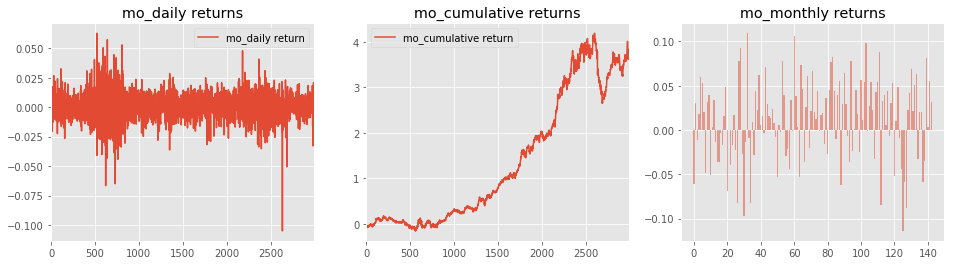

In [24]:
# plot return figures
fig = figure(figsize=[16, 4])
ax1 = fig.add_subplot(131)
mo_df_daily_ret.plot(ax = ax1, title = 'mo_daily returns')
ax2 = fig.add_subplot(132)
mo_df_cum_ret.plot(ax=ax2, title='mo_cumulative returns')
ax3 = fig.add_subplot(133)
mnum = int(periods/21)+1
x = np.arange(mnum)
plt.bar(x, mo_mon_return,  alpha = 0.5)
plt.title('mo_monthly returns')

Text(0.5,1,'mr_monthly returns')

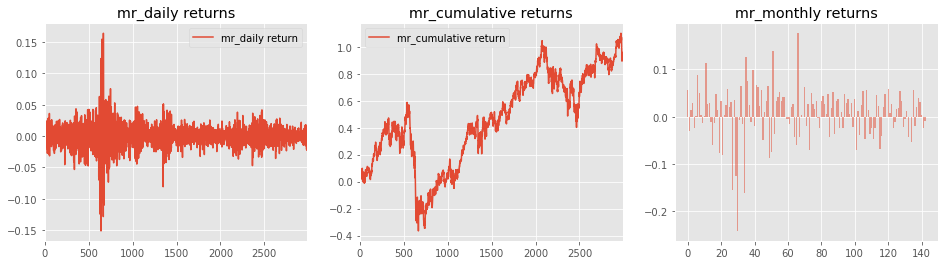

In [25]:
# plot return figures
fig = figure(figsize=[16, 4])
ax1 = fig.add_subplot(131)
mr_df_daily_ret.plot(ax = ax1, title = 'mr_daily returns')
ax2 = fig.add_subplot(132)
mr_df_cum_ret.plot(ax=ax2, title='mr_cumulative returns')
ax3 = fig.add_subplot(133)
mnum = int(periods/21)+1
x = np.arange(mnum)
plt.bar(x, mr_mon_return,  alpha = 0.5)
plt.title('mr_monthly returns')